# Pareto Frontiers for Toggling, Adjoint, and Universal Robustness Objectives (Robustness & Fidelity Trade-off)


## Imports

In [5]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using NamedTrajectories
using Statistics
using CairoMakie
using Random
using ColorSchemes
using Makie
using Printf

  Activating project at `~/Documents/research/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
   Resolving package versions...
  No Changes to `~/Documents/research/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/notebooks/src/Manifest.toml`


In [6]:
# Problem parameters
T = 40
Δt = 0.2
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);

sys = QuantumSystem(H_drive)

∂ₑHₐ = [PAULIS.X, PAULIS.Y, PAULIS.Z]
var_sys = VariationalQuantumSystem(
    H_drive,
    ∂ₑHₐ
)


VariationalQuantumSystem: levels = 2, n_drives = 3

### Pareto Frontiers + Penalty Plots

In [7]:
n_guesses = 15
n_drives = sys.n_drives
var_n_drives = var_sys.n_drives
variational_scales = fill(1.0, length(var_sys.G_vars))
seeds = []

dda_bound_values = [0.01, 0.05, 0.1, 0.5, 1.0]


for dda_val in dda_bound_values
    for seed_idx in 1:3
        Random.seed!(30 * seed_idx)
        
        a_bounds = fill(1.0, n_drives)
        da_bounds = fill(1.0, n_drives)
        dda_bounds = fill(dda_val, n_drives)
        
        control_bounds = (a_bounds, da_bounds, dda_bounds)
        traj = initialize_trajectory(
                        U_goal,
                        T,
                        Δt,
                        n_drives,
                        control_bounds;
                        system=sys
                    )
        push!(seeds, traj)
    end
end

In [9]:
n_seeds = length(seeds)
a_vals = exp.(range(log(100), log(100000), length=8))
final_fid_floor_log = 1 .- 1 ./ a_vals
final_fid_floor = final_fid_floor_log

n_nines = length(final_fid_floor)
default_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_var_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_tog_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_uni_probs = Matrix{Any}(undef, n_seeds, n_nines)

init_def_fids = zeros(n_seeds, n_nines)
init_var_fids = zeros(n_seeds, n_nines)
init_tog_fids = zeros(n_seeds, n_nines)
init_uni_fids = zeros(n_seeds, n_nines)

Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive


for i in 1:n_seeds
    for j in 1:n_nines
        # default case (no robustness)
        default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]))
        default_probs[i, j] = default
        def_fid = unitary_rollout_fidelity(default_probs[i, j].trajectory, sys)
        init_def_fids[i,j] = def_fid

        # variational objective
        var_prob = UnitaryVariationalProblem(var_sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]), robust_times=[[T], [T], [T]], Q_r=0.1, piccolo_options=piccolo_opts)
        init_var_probs[i, j] = var_prob
        var_fid = unitary_rollout_fidelity(init_var_probs[i, j].trajectory, sys)
        init_var_fids[i,j] = var_fid

        # toggling objective
        tog_prob = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]), activate_rob_loss=true, H_err=Hₑ_add, Q_t=0.1)
        init_tog_probs[i, j] = tog_prob
        tog_fid = unitary_rollout_fidelity(init_tog_probs[i, j].trajectory, sys)
        init_tog_fids[i,j] = tog_fid

        # universal objective
        uni_prob = UnitaryUniversalProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]), activate_hyperspeed=true)
        init_uni_probs[i, j] = uni_prob
        uni_fid = unitary_rollout_fidelity(init_uni_probs[i, j].trajectory, sys)
        init_uni_fids[i,j] = uni_fid

    end
end

for i in 1:n_seeds
    for j in 1:n_nines
        
        takes = 1
        while takes < 130 && init_var_fids[i,j] < final_fid_floor[j]
            solve!(init_var_probs[i, j]; max_iter=6, print_level=1, options=IpoptOptions(eval_hessian=false))
            init_var_fid = unitary_rollout_fidelity(init_var_probs[i, j].trajectory, sys)
            init_var_fids[i,j] = init_var_fid
            takes += 1
        end
        
        takes = 1
        while takes < 100 && init_tog_fids[i,j] < final_fid_floor[j]
            solve!(init_tog_probs[i, j]; max_iter=6, print_level=1, options=IpoptOptions(eval_hessian=false))
            init_tog_fid = unitary_rollout_fidelity(init_tog_probs[i, j].trajectory, sys)
            init_tog_fids[i,j] = init_tog_fid
            takes += 1
        end

        takes = 1
        while takes < 100 && init_uni_fids[i,j] < final_fid_floor[j]
            solve!(init_uni_probs[i, j]; max_iter=6, print_level=1, options=IpoptOptions(eval_hessian=false))
            init_uni_fid = unitary_rollout_fidelity(init_uni_probs[i, j].trajectory, sys)
            init_uni_fids[i,j] = init_uni_fid
            takes += 1
        end

        takes = 1
        while takes < 100 && init_def_fids[i,j] < final_fid_floor[j]
            solve!(default_probs[i, j]; max_iter=6, print_level=1)
            def_fid = unitary_rollout_fidelity(default_probs[i, j].trajectory, sys)
            init_def_fids[i, j] = def_fid
            takes += 1
        end

    end
end



    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using i

Excessive output truncated after 524312 bytes.

    initializing optimizer...
        applying constraint: timesteps all equal constraint

Initial Fidelity Summary Table

In [10]:
for seed_idx in 1:n_seeds
    display("\nseed idx = $seed_idx:")
    display("Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | ")
    display("-" ^ 40)
    for (j, f) in enumerate(final_fid_floor)
            def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
            var_fid = unitary_rollout_fidelity(init_var_probs[seed_idx, j].trajectory, var_sys)
            tog_fid = unitary_rollout_fidelity(init_tog_probs[seed_idx, j].trajectory, sys)
            uni_fid = unitary_rollout_fidelity(init_uni_probs[seed_idx, j].trajectory, sys)
            display("$(lpad(round(f, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(var_fid, digits=6), 12)) | $(lpad(round(tog_fid, digits=6), 13)) | $(lpad(round(uni_fid, digits=6), 13)) |")
    end
end

"\nseed idx = 1:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999998 |     0.004817 |      0.999575 |      0.994428 |"

"0.996272 |     0.999998 |     0.004817 |      0.999575 |      0.999916 |"

"0.998611 |     0.999998 |     0.004817 |      0.999575 |      0.999916 |"

"0.999482 |     0.999998 |     0.004817 |      0.999575 |      0.999916 |"

"0.999807 |     0.999998 |     0.004817 |      0.999949 |      0.999916 |"

"0.999928 |     0.999998 |     0.004817 |      0.999949 |      0.999955 |"

"0.999973 |     0.999998 |     0.004817 |      0.999976 |      0.999989 |"

"0.99999 |     0.999998 |     0.004817 |      0.999993 |       0.99999 |"

"\nseed idx = 2:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.998993 |     0.004817 |      0.992263 |      0.999995 |"

"0.996272 |     0.998993 |     0.004817 |      0.998929 |      0.999995 |"

"0.998611 |     0.998993 |     0.004817 |      0.998929 |      0.999995 |"

"0.999482 |     0.999995 |     0.004817 |      0.999949 |      0.999995 |"

"0.999807 |     0.999995 |     0.004817 |      0.999949 |      0.999995 |"

"0.999928 |     0.999995 |     0.004817 |      0.999949 |      0.999995 |"

"0.999973 |     0.999995 |     0.004817 |      0.999982 |      0.999995 |"

"0.99999 |     0.999995 |     0.004817 |      0.999993 |      0.999995 |"

"\nseed idx = 3:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999956 |     0.004817 |      0.998823 |      0.999805 |"

"0.996272 |     0.999956 |     0.004817 |      0.998823 |      0.999805 |"

"0.998611 |     0.999956 |     0.004817 |      0.998823 |      0.999805 |"

"0.999482 |     0.999956 |     0.004817 |      0.999924 |      0.999805 |"

"0.999807 |     0.999956 |     0.004817 |      0.999924 |      0.999918 |"

"0.999928 |     0.999956 |     0.004817 |      0.999996 |      0.999936 |"

"0.999973 |     0.999987 |     0.004817 |      0.999996 |       0.99998 |"

"0.99999 |          1.0 |     0.004817 |      0.999996 |      0.999993 |"

"\nseed idx = 4:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999962 |     0.644861 |      0.999406 |       0.99993 |"

"0.996272 |     0.999962 |     0.644861 |      0.999406 |       0.99993 |"

"0.998611 |     0.999962 |     0.644861 |      0.999406 |       0.99993 |"

"0.999482 |     0.999962 |     0.644861 |      0.999999 |       0.99993 |"

"0.999807 |     0.999962 |     0.644861 |      0.999999 |       0.99993 |"

"0.999928 |     0.999962 |     0.644861 |      0.999999 |       0.99993 |"

"0.999973 |          1.0 |     0.644861 |      0.999999 |      0.999999 |"

"0.99999 |          1.0 |     0.644861 |      0.999999 |      0.999999 |"

"\nseed idx = 5:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999901 |          0.0 |      0.999965 |      0.998837 |"

"0.996272 |     0.999901 |          0.0 |      0.999965 |      0.998837 |"

"0.998611 |     0.999901 |          0.0 |      0.999965 |      0.998837 |"

"0.999482 |     0.999901 |          0.0 |      0.999965 |      0.999943 |"

"0.999807 |     0.999901 |          0.0 |      0.999965 |      0.999943 |"

"0.999928 |          1.0 |          0.0 |      0.999965 |      0.999943 |"

"0.999973 |          1.0 |          0.0 |      0.999993 |      0.999999 |"

"0.99999 |          1.0 |          0.0 |      0.999993 |      0.999999 |"

"\nseed idx = 6:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.998962 |     0.644861 |      0.999237 |       0.99998 |"

"0.996272 |     0.998962 |     0.644861 |      0.999237 |       0.99998 |"

"0.998611 |     0.998962 |     0.644861 |      0.999237 |       0.99998 |"

"0.999482 |     0.999998 |     0.644861 |      0.999985 |       0.99998 |"

"0.999807 |     0.999998 |     0.644861 |      0.999985 |       0.99998 |"

"0.999928 |     0.999998 |     0.644861 |      0.999985 |       0.99998 |"

"0.999973 |     0.999998 |     0.644861 |      0.999985 |       0.99998 |"

"0.99999 |     0.999998 |     0.644861 |           1.0 |      0.999999 |"

"\nseed idx = 7:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.991691 |     0.995059 |      0.996505 |      0.995758 |"

"0.996272 |     0.999984 |     0.993848 |      0.996505 |      0.999896 |"

"0.998611 |     0.999984 |     0.993848 |      0.999995 |      0.999896 |"

"0.999482 |     0.999984 |     0.993848 |      0.999995 |      0.999896 |"

"0.999807 |     0.999984 |     0.993848 |      0.999995 |      0.999896 |"

"0.999928 |     0.999984 |     0.993848 |      0.999995 |      0.999987 |"

"0.999973 |     0.999984 |     0.993848 |      0.999995 |      0.999987 |"

"0.99999 |          1.0 |     0.993848 |      0.999995 |      0.999996 |"

"\nseed idx = 8:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.994978 |          0.0 |      0.993274 |      0.999877 |"

"0.996272 |     0.999984 |          0.0 |      0.999976 |      0.999877 |"

"0.998611 |     0.999984 |          0.0 |      0.999976 |      0.999877 |"

"0.999482 |     0.999984 |          0.0 |      0.999976 |      0.999877 |"

"0.999807 |     0.999984 |          0.0 |      0.999976 |      0.999877 |"

"0.999928 |     0.999984 |          0.0 |      0.999976 |       0.99997 |"

"0.999973 |     0.999984 |          0.0 |      0.999976 |      0.999996 |"

"0.99999 |          1.0 |          0.0 |      0.999996 |      0.999996 |"

"\nseed idx = 9:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999715 |     0.996191 |      0.997747 |      0.997825 |"

"0.996272 |     0.999715 |     0.993848 |      0.997747 |      0.997825 |"

"0.998611 |     0.999715 |     0.993848 |      0.999725 |      0.999355 |"

"0.999482 |     0.999715 |     0.993848 |      0.999725 |      0.999947 |"

"0.999807 |          1.0 |     0.993848 |      0.999993 |      0.999947 |"

"0.999928 |          1.0 |     0.993848 |      0.999993 |      0.999947 |"

"0.999973 |          1.0 |     0.993848 |      0.999993 |      0.999995 |"

"0.99999 |          1.0 |     0.993848 |      0.999993 |      0.999995 |"

"\nseed idx = 10:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999993 |     0.992303 |      0.999096 |      0.990748 |"

"0.996272 |     0.999993 |     0.991985 |      0.999096 |      0.999936 |"

"0.998611 |     0.999993 |     0.991985 |      0.999096 |      0.999936 |"

"0.999482 |     0.999993 |     0.991985 |           1.0 |      0.999936 |"

"0.999807 |     0.999993 |     0.991985 |           1.0 |      0.999936 |"

"0.999928 |     0.999993 |     0.991985 |           1.0 |      0.999936 |"

"0.999973 |     0.999993 |     0.991985 |           1.0 |      0.999998 |"

"0.99999 |     0.999993 |     0.991985 |           1.0 |      0.999998 |"

"\nseed idx = 11:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999339 |     0.995672 |       0.99985 |      0.999813 |"

"0.996272 |     0.999339 |      0.99898 |       0.99985 |      0.999813 |"

"0.998611 |     0.999339 |      0.99898 |       0.99985 |      0.999813 |"

"0.999482 |     0.999978 |     0.999917 |       0.99985 |      0.999813 |"

"0.999807 |     0.999978 |     0.999917 |       0.99985 |      0.999813 |"

"0.999928 |     0.999978 |     0.999987 |      0.999976 |      0.999993 |"

"0.999973 |     0.999978 |     0.999987 |      0.999976 |      0.999993 |"

"0.99999 |          1.0 |     0.999994 |           1.0 |      0.999993 |"

"\nseed idx = 12:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.994806 |     0.995806 |      0.998895 |      0.998833 |"

"0.996272 |     0.999487 |     0.998291 |      0.998895 |      0.998833 |"

"0.998611 |     0.999487 |     0.999637 |      0.998895 |      0.998833 |"

"0.999482 |     0.999487 |     0.999637 |           1.0 |      0.999998 |"

"0.999807 |     0.999998 |     0.999979 |           1.0 |      0.999998 |"

"0.999928 |     0.999998 |     0.999979 |           1.0 |      0.999998 |"

"0.999973 |     0.999998 |     0.999979 |           1.0 |      0.999998 |"

"0.99999 |     0.999998 |     0.999999 |           1.0 |      0.999998 |"

"\nseed idx = 13:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999538 |     0.995849 |      0.996654 |      0.999992 |"

"0.996272 |     0.999538 |     0.998469 |      0.996654 |      0.999992 |"

"0.998611 |     0.999538 |     0.999193 |           1.0 |      0.999992 |"

"0.999482 |     0.999538 |     0.999576 |           1.0 |      0.999992 |"

"0.999807 |     0.999995 |     0.999828 |           1.0 |      0.999992 |"

"0.999928 |     0.999995 |     0.999993 |           1.0 |      0.999992 |"

"0.999973 |     0.999995 |     0.999993 |           1.0 |      0.999992 |"

"0.99999 |     0.999995 |     0.999993 |           1.0 |      0.999992 |"

"\nseed idx = 14:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999696 |     0.991306 |      0.994504 |      0.999986 |"

"0.996272 |     0.999696 |     0.998513 |      0.999957 |      0.999986 |"

"0.998611 |     0.999696 |     0.999805 |      0.999957 |      0.999986 |"

"0.999482 |     0.999696 |     0.999805 |      0.999957 |      0.999986 |"

"0.999807 |     0.999997 |     0.999954 |      0.999957 |      0.999986 |"

"0.999928 |     0.999997 |     0.999954 |      0.999957 |      0.999986 |"

"0.999973 |     0.999997 |     0.999985 |      0.999999 |      0.999986 |"

"0.99999 |     0.999997 |     0.999995 |      0.999999 |      0.999996 |"

"\nseed idx = 15:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.998803 |     0.993953 |      0.995594 |      0.997025 |"

"0.996272 |     0.998803 |     0.996812 |      0.999894 |      0.997025 |"

"0.998611 |     0.998803 |     0.998763 |      0.999894 |      0.999958 |"

"0.999482 |     0.999941 |     0.999185 |      0.999894 |      0.999958 |"

"0.999807 |     0.999941 |     0.999185 |      0.999894 |      0.999958 |"

"0.999928 |     0.999941 |     0.999185 |      0.999997 |      0.999958 |"

"0.999973 |     0.999991 |     0.999185 |      0.999997 |      0.999993 |"

"0.99999 |     0.999991 |     0.999185 |      0.999997 |      0.999993 |"

Solve Max-Toggle Problems

In [11]:
n_nines = length(final_fid_floor)
final_var_probs = Matrix{Any}(undef, n_seeds, n_nines)
final_tog_probs = Matrix{Any}(undef, n_seeds, n_nines)
final_uni_probs = Matrix{Any}(undef, n_seeds, n_nines)

Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]

for i in 1:n_seeds
    for j in 1:n_nines

        var_prob = UnitaryVariationalProblem(
                var_sys,  U_goal, T, Δt;
                robust_times=[[T], [T], [T]],
                Q=0.0,
                Q_r=1.0,
                init_trajectory=init_var_probs[i,j].trajectory,
                var_seed=false,
                piccolo_options=piccolo_opts
            )
        F = final_fid_floor[j]
        push!(var_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, var_prob.trajectory))
        solve!(var_prob, max_iter=750, print_level=5,options=IpoptOptions(eval_hessian=false))
        solve!(var_prob, max_iter=25, print_level=5)
        final_var_probs[i,j] = var_prob

    end
end



In [12]:

for i in 1:n_seeds
    for j in 1:n_nines

        tog_prob = UnitaryMaxToggleProblem(
                init_tog_probs[i,j],
                U_goal,
                Hₑ_add;
                Q_t=1.0,
                final_fidelity=final_fid_floor[j],
                piccolo_options=piccolo_opts
            )
        solve!(tog_prob, max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(tog_prob, max_iter=25, print_level=5)
        final_tog_probs[i,j] = tog_prob

    end
end



In [13]:

for i in 1:n_seeds
    for j in 1:n_nines

        uni_prob = UnitaryMaxUniversalProblem(
                init_uni_probs[i,j],
                U_goal;
                Q_t=1.0,
                final_fidelity=final_fid_floor[j],
                piccolo_options=piccolo_opts
            )
        solve!(uni_prob, max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(uni_prob, max_iter=25, print_level=5)
        final_uni_probs[i,j] = uni_prob

    end
end



Pareto Frontiers

In [14]:
function SpaceCurve(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    T = traj.T
    first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
    first_order_integral = zeros(ComplexF64, size(U_goal))

    for i in 1:T
        U = iso_vec_to_operator(traj.Ũ⃗[:, i])
        first_order_integral += U' * H_err * U
        first_order_terms[i] = first_order_integral
    end
    d = size(U_goal)[1]
    space_curve = [[real(tr(PAULIS.X * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Y * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Z * first_order_terms[t] / (d * T)))] for t in 1:T] 
    return space_curve
end

function space_curve_robustness(traj::NamedTrajectory, U_goal::AbstractMatrix, H_err::AbstractMatrix)
    curve = SpaceCurve(traj, U_goal, H_err)
    # Use the norm of the final point as a robustness measure
    # (larger values indicate more accumulated error sensitivity)
    final_point = curve[end]
    return norm(final_point)
end


space_curve_robustness (generic function with 1 method)

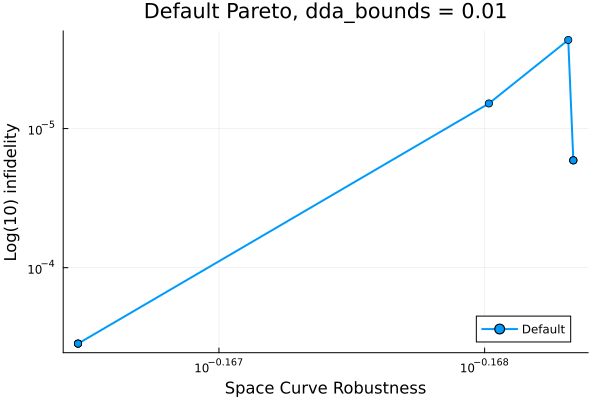

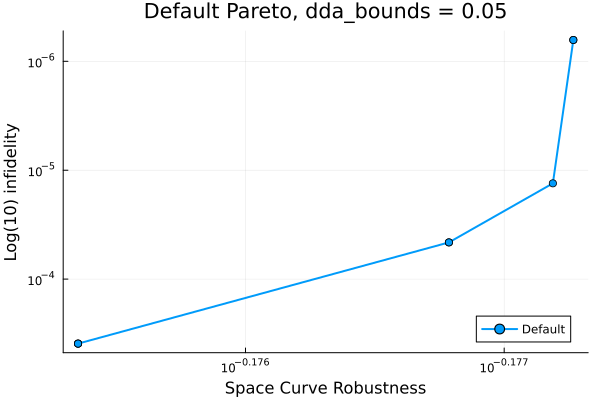

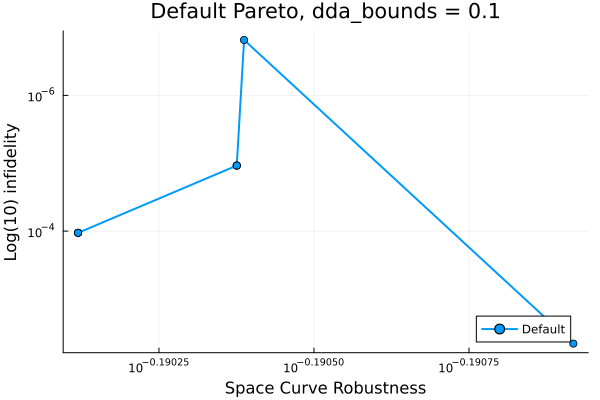

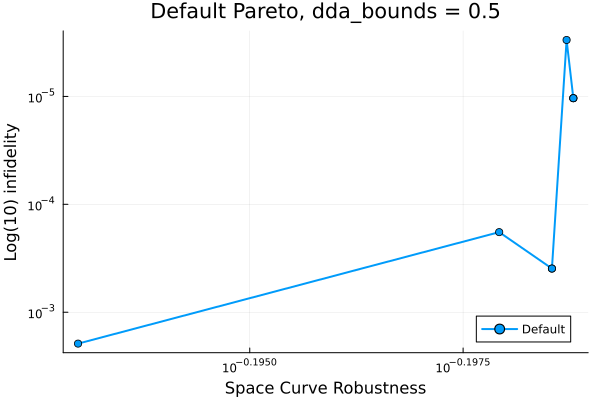

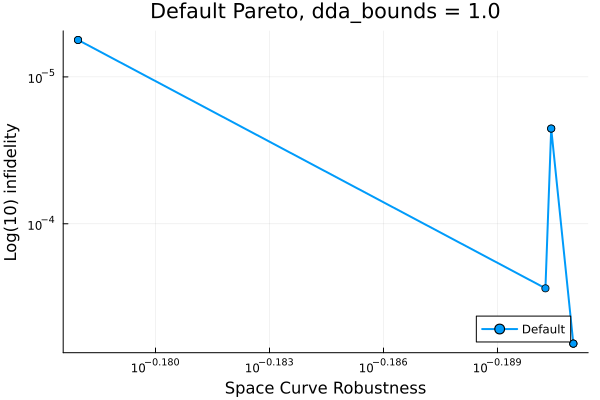

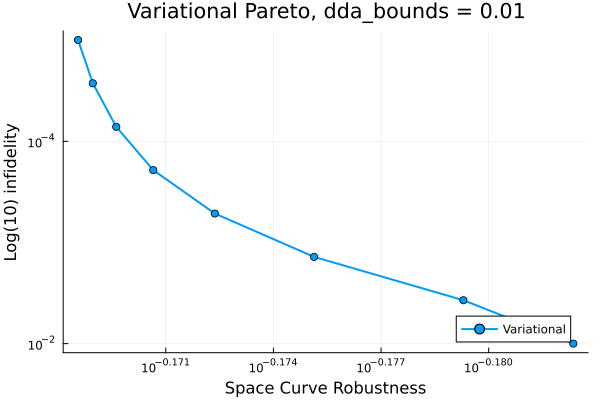

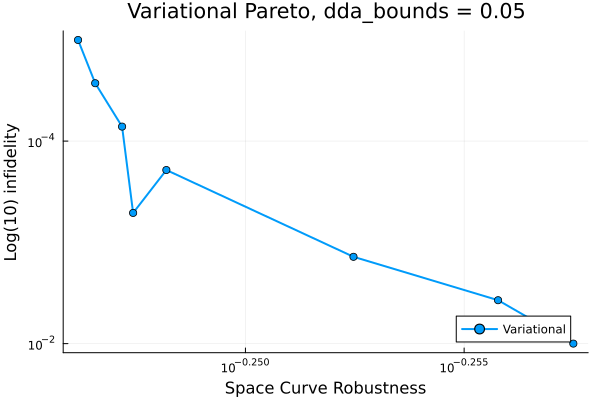

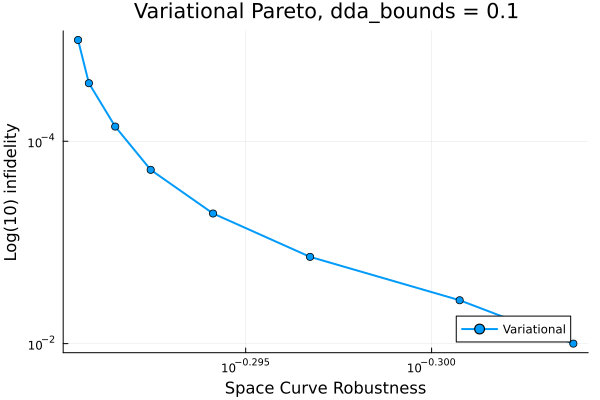

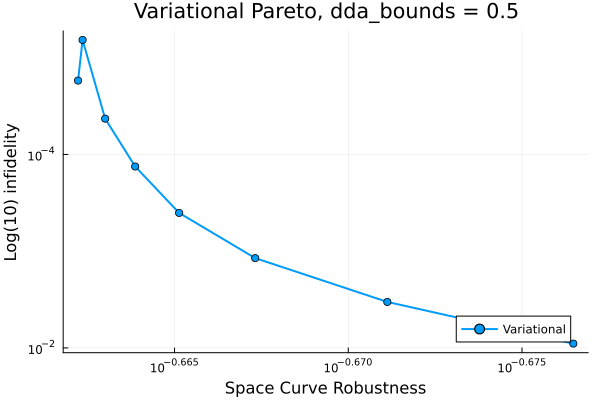

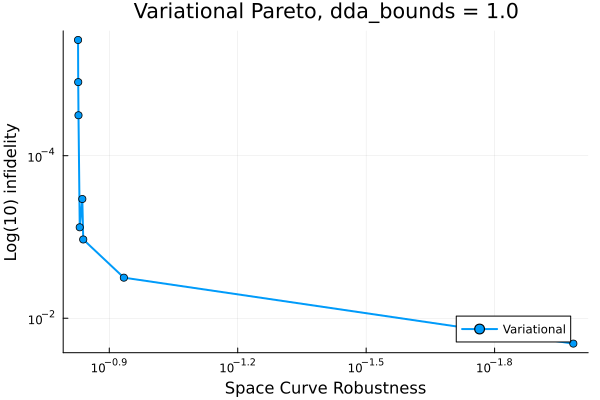

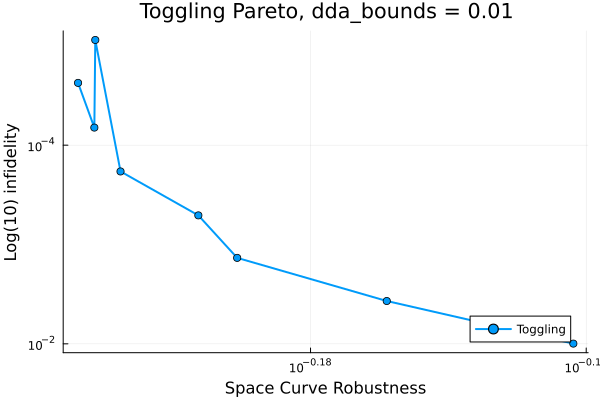

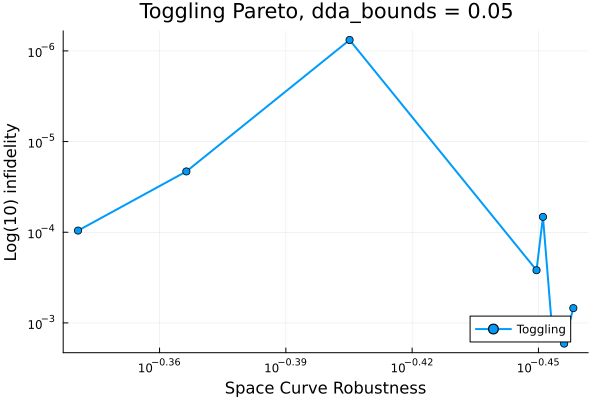

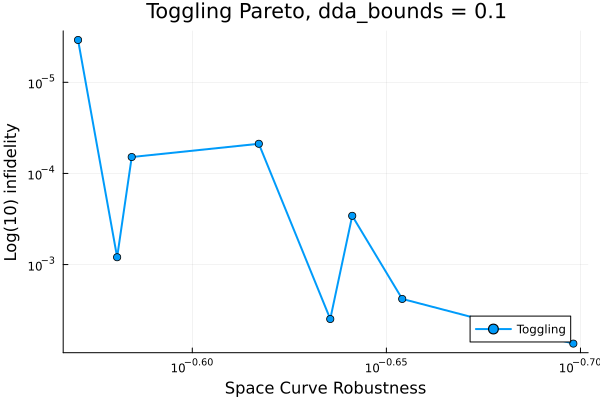

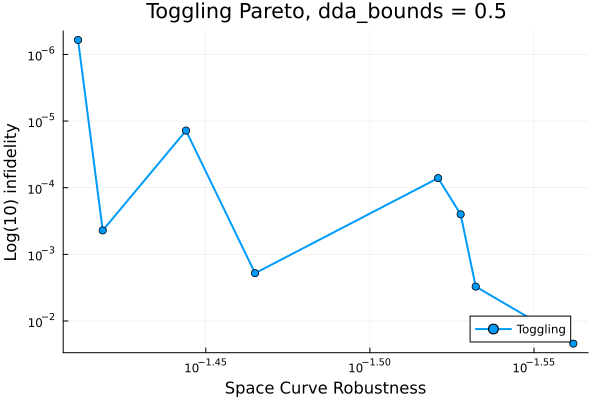

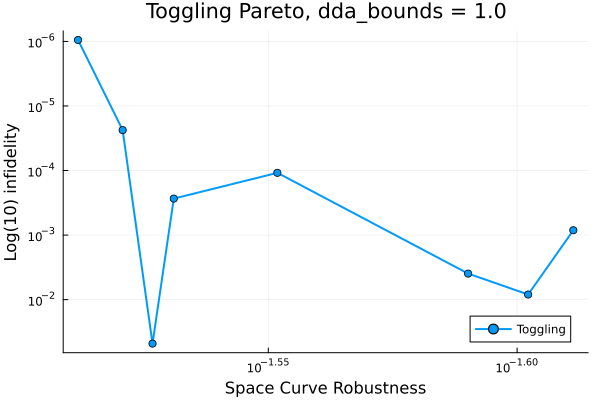

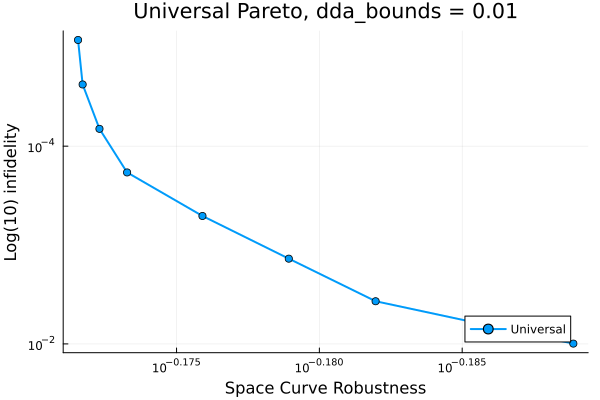

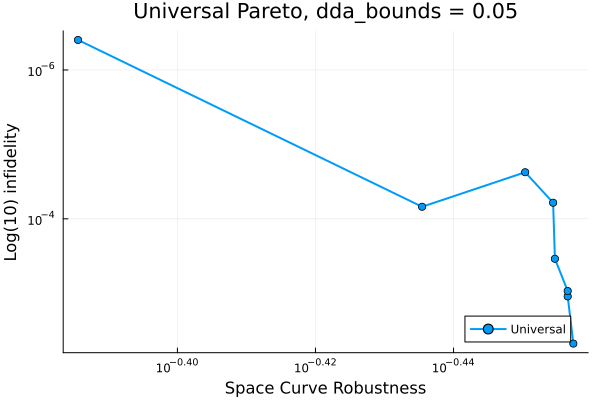

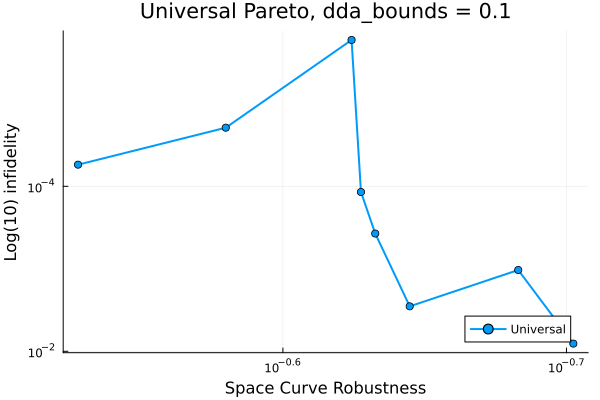

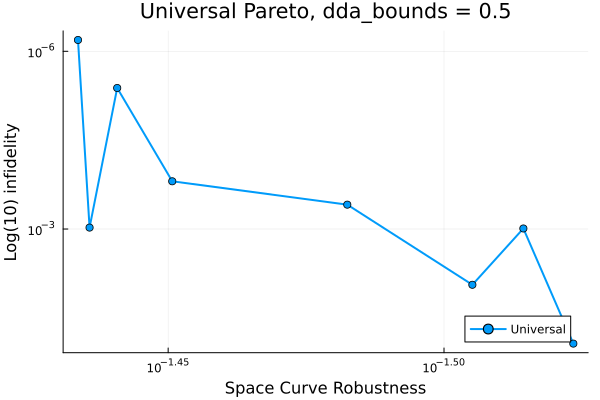

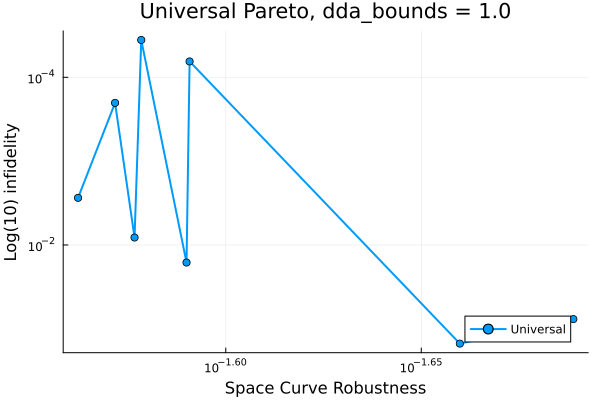

In [15]:
arr_probs = [default_probs, final_var_probs, final_tog_probs, final_uni_probs]
method_names = ["Default", "Variational", "Toggling", "Universal"]

dda_bound_values = [0.01, 0.05, 0.1, 0.5, 1.0]

for (prob_idx, probs) in enumerate(arr_probs)
    method_name = method_names[prob_idx]
    
    # Loop through each of the 5 dda_bound values
    for dda_idx in 1:5
        dda = dda_bound_values[dda_idx]
        
        plt = Plots.plot(
            xlabel="Space Curve Robustness",
            ylabel="Log(10) infidelity",
            title="$method_name Pareto, dda_bounds = $dda",
            xscale = :log10, yscale = :log10,
            legend=:bottomright, grid=true,
            xflip=true,
            yflip=true
        )
        
        xs = Float64[]  # robustness from space curve
        ys = Float64[]  # infidelity
        
        for (j, f) in enumerate(final_fid_floor)
            # Average over the 3 seeds for this dda_bound value
            seed_indices = [(dda_idx-1)*3 + 1, (dda_idx-1)*3 + 2, (dda_idx-1)*3 + 3]
            
            avg_robustness_sum = 0.0
            avg_infidelity_sum = 0.0
            
            for seed_idx in seed_indices
                prob = probs[seed_idx, j]
                
                # Compute robustness using space curve
                X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
                Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
                Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
                avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
                infidelity = 1 - unitary_rollout_fidelity(prob.trajectory, sys)
                
                avg_robustness_sum += avg_robustness
                avg_infidelity_sum += infidelity
            end
            
            # Take average over the 3 seeds
            final_avg_robustness = avg_robustness_sum / 3
            final_avg_infidelity = avg_infidelity_sum / 3
            
            push!(xs, final_avg_robustness)
            push!(ys, final_avg_infidelity)
        end
        
        # Sort by x-axis for smooth line
        ord = sortperm(xs)
        Plots.plot!(plt, xs[ord], ys[ord], marker=:circle, label=method_name, linewidth=2)
        display(plt)
    end
end

In [16]:
for seed_idx in 1:n_seeds
    display("\nseed idx = $seed_idx:")
    display("Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | ")
    display("-" ^ 40)
    for (j, f) in enumerate(final_fid_floor)
            def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
            var_fid = unitary_rollout_fidelity(final_var_probs[seed_idx, j].trajectory, var_sys)
            tog_fid = unitary_rollout_fidelity(final_tog_probs[seed_idx, j].trajectory, sys)
            uni_fid = unitary_rollout_fidelity(final_uni_probs[seed_idx, j].trajectory, sys)
            display("$(lpad(round(f, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(var_fid, digits=6), 12)) | $(lpad(round(tog_fid, digits=6), 13)) | $(lpad(round(uni_fid, digits=6), 13)) |")
    end
end

"\nseed idx = 1:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999998 |         0.99 |      0.990079 |      0.990073 |"

"0.996272 |     0.999998 |     0.996272 |      0.996317 |      0.996314 |"

"0.998611 |     0.999998 |     0.998611 |      0.998636 |      0.998635 |"

"0.999482 |     0.999998 |     0.999482 |      0.999478 |      0.999494 |"

"0.999807 |     0.999998 |     0.999807 |      0.999816 |      0.999816 |"

"0.999928 |     0.999998 |     0.999928 |      0.999933 |      0.999933 |"

"0.999973 |     0.999998 |     0.999973 |      0.999976 |      0.999976 |"

"0.99999 |     0.999998 |      0.99999 |      0.999992 |      0.999991 |"

"\nseed idx = 2:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.998993 |         0.99 |      0.990058 |      0.990073 |"

"0.996272 |     0.998993 |     0.996272 |      0.996246 |      0.996314 |"

"0.998611 |     0.998993 |     0.998611 |      0.998636 |      0.998635 |"

"0.999482 |     0.999995 |     0.999482 |      0.999497 |      0.999485 |"

"0.999807 |     0.999995 |     0.999807 |      0.999816 |      0.999816 |"

"0.999928 |     0.999995 |     0.999928 |      0.999933 |      0.999933 |"

"0.999973 |     0.999995 |     0.999973 |      0.999976 |      0.999976 |"

"0.99999 |     0.999995 |      0.99999 |       0.99999 |      0.999992 |"

"\nseed idx = 3:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999956 |         0.99 |      0.990006 |      0.990073 |"

"0.996272 |     0.999956 |     0.996272 |      0.996317 |      0.996269 |"

"0.998611 |     0.999956 |     0.998611 |      0.998636 |       0.99861 |"

"0.999482 |     0.999956 |     0.999482 |      0.999497 |      0.999496 |"

"0.999807 |     0.999956 |     0.999807 |      0.999816 |      0.999816 |"

"0.999928 |     0.999956 |     0.999928 |      0.999933 |      0.999933 |"

"0.999973 |     0.999987 |     0.999973 |      0.999976 |      0.999976 |"

"0.99999 |          1.0 |      0.99999 |      0.999992 |      0.999991 |"

"\nseed idx = 4:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999962 |         0.99 |      0.998183 |      0.993913 |"

"0.996272 |     0.999962 |     0.996272 |      0.998414 |      0.999379 |"

"0.998611 |     0.999962 |     0.998611 |      0.999632 |       0.99782 |"

"0.999482 |     0.999962 |     0.999482 |      0.999738 |      0.999726 |"

"0.999807 |     0.999962 |     0.999807 |      0.999921 |      0.999951 |"

"0.999928 |     0.999962 |     0.999928 |      0.999998 |      0.999965 |"

"0.999973 |          1.0 |     0.999973 |      0.999993 |      0.999825 |"

"0.99999 |          1.0 |      0.99999 |           1.0 |           1.0 |"

"\nseed idx = 5:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999901 |         0.99 |      0.999176 |      0.997923 |"

"0.996272 |     0.999901 |     0.996272 |      0.999378 |      0.999392 |"

"0.998611 |     0.999901 |     0.998611 |      0.999632 |      0.999625 |"

"0.999482 |     0.999901 |     0.999499 |      0.999738 |      0.999726 |"

"0.999807 |     0.999901 |     0.999807 |      0.999957 |      0.999951 |"

"0.999928 |          1.0 |     0.999928 |       0.99999 |      0.999986 |"

"0.999973 |          1.0 |     0.999973 |      0.999992 |      0.999976 |"

"0.99999 |          1.0 |      0.99999 |      0.999999 |           1.0 |"

"\nseed idx = 6:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.998962 |         0.99 |      0.997567 |      0.993913 |"

"0.996272 |     0.998962 |     0.996272 |      0.998414 |       0.99843 |"

"0.998611 |     0.998962 |     0.998611 |      0.998676 |      0.999245 |"

"0.999482 |     0.999998 |     0.999482 |      0.999738 |      0.999514 |"

"0.999807 |     0.999998 |     0.999807 |      0.999919 |      0.999915 |"

"0.999928 |     0.999998 |     0.999928 |      0.999948 |      0.999977 |"

"0.999973 |     0.999998 |     0.999973 |      0.999728 |      0.999992 |"

"0.99999 |     0.999998 |      0.99999 |      0.999999 |           1.0 |"

"\nseed idx = 7:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.991691 |         0.99 |      0.997191 |      0.995026 |"

"0.996272 |     0.999984 |     0.996272 |      0.992205 |       0.99741 |"

"0.998611 |     0.999984 |     0.998611 |      0.997565 |      0.998812 |"

"0.999482 |     0.999984 |     0.999482 |      0.999532 |      0.999952 |"

"0.999807 |     0.999984 |     0.999807 |      0.999929 |      0.999955 |"

"0.999928 |     0.999984 |     0.999928 |      0.999996 |      0.999945 |"

"0.999973 |     0.999984 |     0.999973 |      0.999985 |      0.999962 |"

"0.99999 |          1.0 |      0.99999 |      0.999995 |           1.0 |"

"\nseed idx = 8:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.994978 |     0.990001 |      0.991175 |       0.99095 |"

"0.996272 |     0.999984 |     0.996273 |      0.997894 |      0.997414 |"

"0.998611 |     0.999984 |     0.998612 |       0.99664 |      0.998489 |"

"0.999482 |     0.999984 |     0.999483 |      0.998439 |      0.999322 |"

"0.999807 |     0.999984 |     0.999811 |       0.99999 |      0.999824 |"

"0.999928 |     0.999984 |     0.999929 |      0.999247 |      0.999945 |"

"0.999973 |     0.999984 |     0.999974 |      0.999983 |      0.999996 |"

"0.99999 |          1.0 |      0.99999 |      0.999995 |           1.0 |"

"\nseed idx = 9:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999715 |         0.99 |      0.989529 |      0.989803 |"

"0.996272 |     0.999715 |     0.996272 |      0.998026 |      0.996625 |"

"0.998611 |     0.999715 |     0.998611 |      0.998648 |      0.999596 |"

"0.999482 |     0.999715 |     0.999482 |      0.999537 |      0.999605 |"

"0.999807 |          1.0 |     0.999807 |       0.99994 |      0.999869 |"

"0.999928 |          1.0 |     0.999928 |      0.999881 |      0.999945 |"

"0.999973 |          1.0 |     0.999973 |      0.999834 |      0.999984 |"

"0.99999 |          1.0 |      0.99999 |           1.0 |      0.999995 |"

"\nseed idx = 10:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999993 |         0.99 |       0.99124 |      0.991276 |"

"0.996272 |     0.999993 |     0.996272 |       0.99687 |       0.75768 |"

"0.998611 |     0.999993 |     0.998611 |      0.998965 |      0.999036 |"

"0.999482 |     0.999993 |     0.999482 |       0.99969 |      0.999692 |"

"0.999807 |     0.999993 |     0.999807 |      0.999916 |      0.999912 |"

"0.999928 |     0.999993 |     0.999928 |      0.999978 |      0.999878 |"

"0.999973 |     0.999993 |     0.999973 |      0.999991 |      0.999995 |"

"0.99999 |     0.999993 |      0.99999 |      0.999999 |      0.999999 |"

"\nseed idx = 11:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999339 |     0.991029 |      0.990063 |      0.991226 |"

"0.996272 |     0.999339 |     0.996842 |      0.997052 |      0.997212 |"

"0.998611 |     0.999339 |     0.998927 |       0.99632 |      0.999005 |"

"0.999482 |     0.999978 |     0.999656 |      0.999324 |      0.999457 |"

"0.999807 |     0.999978 |     0.999894 |      0.999546 |      0.999702 |"

"0.999928 |     0.999978 |     0.999972 |      0.999964 |      0.999987 |"

"0.999973 |     0.999978 |     0.999982 |      0.999991 |      0.999995 |"

"0.99999 |          1.0 |     0.999999 |      0.999999 |           1.0 |"

"\nseed idx = 12:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.994806 |     0.991888 |      0.953158 |      0.991276 |"

"0.996272 |     0.999487 |     0.996839 |       0.99693 |      0.987034 |"

"0.998611 |     0.999487 |     0.998922 |      0.998964 |       0.99912 |"

"0.999482 |     0.999487 |     0.999655 |      0.999674 |      0.999687 |"

"0.999807 |     0.999998 |     0.999899 |      0.999786 |      0.999916 |"

"0.999928 |     0.999998 |     0.999972 |      0.999842 |      0.997197 |"

"0.999973 |     0.999998 |     0.999994 |      0.999977 |      0.999998 |"

"0.99999 |     0.999998 |     0.999991 |      0.999999 |      0.999999 |"

"\nseed idx = 13:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999538 |      0.98722 |      0.991857 |      0.991687 |"

"0.996272 |     0.999538 |     0.997194 |      0.860029 |      0.997175 |"

"0.998611 |     0.999538 |     0.999065 |      0.998895 |      0.999099 |"

"0.999482 |     0.999538 |     0.999724 |      0.999725 |      0.575668 |"

"0.999807 |     0.999995 |      0.99795 |      0.988332 |      0.953968 |"

"0.999928 |     0.999995 |     0.999984 |      0.999985 |      0.999415 |"

"0.999973 |     0.999995 |     0.999994 |      0.999998 |      0.999997 |"

"0.99999 |     0.999995 |     0.999999 |           1.0 |      0.999996 |"

"\nseed idx = 14:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999696 |     0.986218 |      0.991427 |      0.992179 |"

"0.996272 |     0.999696 |     0.997221 |      0.996832 |      0.997174 |"

"0.998611 |     0.999696 |     0.999102 |      0.999389 |      0.999205 |"

"0.999482 |     0.999696 |      0.99977 |      0.999735 |      0.974403 |"

"0.999807 |     0.999997 |     0.999961 |      0.999877 |      0.987264 |"

"0.999928 |     0.999997 |     0.999992 |      0.999702 |      0.999989 |"

"0.999973 |     0.999997 |     0.999995 |      0.999965 |      0.999978 |"

"0.99999 |     0.999997 |     0.999999 |      0.999998 |      0.999926 |"

"\nseed idx = 15:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.998803 |     0.964969 |      0.991723 |      0.991697 |"

"0.996272 |     0.998803 |     0.996077 |      0.999209 |      0.997432 |"

"0.998611 |     0.998803 |     0.998611 |      0.999193 |      0.953114 |"

"0.999482 |     0.999941 |     0.999482 |      0.999724 |      0.999739 |"

"0.999807 |     0.999941 |     0.999807 |      0.999942 |      0.829221 |"

"0.999928 |     0.999941 |     0.999928 |      0.999987 |      0.999991 |"

"0.999973 |     0.999991 |     0.999973 |      0.999966 |      0.999918 |"

"0.99999 |     0.999991 |      0.99999 |           1.0 |      0.999884 |"

Penalty

In [ ]:
sweep_rob_loss_λ = exp.(range(log(.1), log(100), length=8))
n_lambdas = length(sweep_rob_loss_λ)

pen_var_probs = Matrix{Any}(undef, n_seeds, n_lambdas)
pen_tog_probs = Matrix{Any}(undef, n_seeds, n_lambdas)
pen_uni_probs = Matrix{Any}(undef, n_seeds, n_lambdas)

Hₑ_add = a -> PAULIS.X + PAULIS.Y + PAULIS.Z
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive


for i in 1:n_seeds
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ) 

        # var problem
        var_prob = UnitaryVariationalProblem(
            var_sys, U_goal, T, Δt;
            init_trajectory=deepcopy(init_var_probs[i,λ_idx].trajectory),
            piccolo_options=piccolo_opts,
            var_seed=false,
            Q_r=λ
        )
        solve!(var_prob; max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(var_prob; max_iter=25, print_level=5)
        pen_var_probs[i, λ_idx] = var_prob

        # tog problem
        tog_prob = UnitarySmoothPulseProblem(
            sys, U_goal, T, Δt;
            init_trajectory=deepcopy(seeds[i]),
            piccolo_options=piccolo_opts,
            activate_rob_loss=true,
            H_err=Hₑ_add,
            Q_t=λ
        )
        solve!(tog_prob; max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(tog_prob; max_iter=25, print_level=5)
        pen_tog_probs[i, λ_idx] = tog_prob

        # uni problem
        uni_prob = UnitaryUniversalProblem(
            sys, U_goal, T, Δt;
            init_trajectory=deepcopy(seeds[i]),
            piccolo_options=piccolo_opts,
            activate_hyperspeed=true,
            Q_t=λ
        )
        solve!(uni_prob; max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(uni_prob; max_iter=25, print_level=5)
        pen_uni_probs[i, λ_idx] = uni_prob
    end
end


### Full Plots

In [14]:
# function compute_space_curve_robustness(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
#     """Compute the average norm of the space curve over Pauli X, Y, Z"""
#     space_curve = SpaceCurve(traj, U_goal, H_err)
    
#     # Extract X, Y, Z components for each time step
#     x_components = [sc[1] for sc in space_curve]
#     y_components = [sc[2] for sc in space_curve]
#     z_components = [sc[3] for sc in space_curve]
    
#     # Compute norms for each Pauli direction
#     x_norm = norm(x_components)
#     y_norm = norm(y_components)
#     z_norm = norm(z_components)
    
#     # Return average norm
#     return (x_norm + y_norm + z_norm) / 3.0
# end

#### pareto with penalty

In [ ]:
# Define colors for methods
method_colors = [:blue, :red, :green]
method_names_plot = ["Variational", "Toggling", "Universal"]

for (method_idx, method_name) in enumerate(method_names_plot)
    println("Processing $method_name method...")
    
    # Get the appropriate problem arrays
    if method_idx == 1  # Variational
        pareto_probs = final_var_probs
        penalty_probs = pen_var_probs
    elseif method_idx == 2  # Toggling
        pareto_probs = final_tog_probs
        penalty_probs = pen_tog_probs
    else  # Universal
        pareto_probs = final_uni_probs
        penalty_probs = pen_uni_probs
    end
    
    # Loop through each of the 5 dda_bound values
    for dda_idx in 1:5
        dda = dda_bound_values[dda_idx]
        
        fig = Figure(resolution=(800, 600))
        ax = Axis(fig[1, 1], 
                 xlabel="Average Space Curve Robustness", 
                 ylabel="Fidelity",
                 title="$method_name Method: Pareto Frontier and Penalty Points (dda_bounds = $dda)")
        
        # Seed indices for this dda_bound value (3 seeds per dda_bound)
        seed_indices = [(dda_idx-1)*3 + 1, (dda_idx-1)*3 + 2, (dda_idx-1)*3 + 3]
        
        # Pareto frontier points (averaged over 3 seeds)
        pareto_x = Float64[]
        pareto_y = Float64[]
        
        for j in 1:n_nines
            avg_robustness_sum = 0.0
            avg_fidelity_sum = 0.0
            
            # Average over the 3 seeds for this dda_bound value
            for seed_idx in seed_indices
                prob = pareto_probs[seed_idx, j]
                X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
                Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
                Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
                avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
                fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
                
                avg_robustness_sum += avg_robustness
                avg_fidelity_sum += fidelity
            end
            
            # Take average over the 3 seeds
            final_avg_robustness = avg_robustness_sum / 3
            final_avg_fidelity = avg_fidelity_sum / 3
            
            push!(pareto_x, final_avg_robustness)
            push!(pareto_y, final_avg_fidelity)
        end
        
        # Sort by x-axis for smooth line
        ord = sortperm(pareto_x)
        lines!(ax, pareto_x[ord], pareto_y[ord], 
               color=method_colors[method_idx], linewidth=2, 
               label="Pareto Frontier")
        Makie.scatter!(ax, pareto_x[ord], pareto_y[ord], 
                color=method_colors[method_idx], markersize=8)
        
        # Penalty points (averaged over 3 seeds)
        penalty_x = Float64[]
        penalty_y = Float64[]
        lambda_vals = Float64[]
        
        for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
            avg_robustness_sum = 0.0
            avg_fidelity_sum = 0.0
            
            # Average over the 3 seeds for this dda_bound value
            for seed_idx in seed_indices
                prob = penalty_probs[seed_idx, λ_idx]
                X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
                Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
                Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
                avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
                fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
                
                avg_robustness_sum += avg_robustness
                avg_fidelity_sum += fidelity
            end
            
            # Take average over the 3 seeds
            final_avg_robustness = avg_robustness_sum / 3
            final_avg_fidelity = avg_fidelity_sum / 3
            
            push!(penalty_x, final_avg_robustness)
            push!(penalty_y, final_avg_fidelity)
            push!(lambda_vals, λ)
        end
        
        # Color penalty points by lambda value
        Makie.scatter!(ax, penalty_x, penalty_y, 
                color=lambda_vals, colormap=:viridis, markersize=6,
                label="Penalty Points")
        
        # Add colorbar for lambda values
        Colorbar(fig[1, 2], limits=(minimum(sweep_rob_loss_λ), maximum(sweep_rob_loss_λ)),
                 colormap=:viridis, label="λ value")
        
        axislegend(ax, position=:lb)
        display(fig)
    end
end

In [ ]:
for (method_idx, method_name) in enumerate(method_names_plot)
    println("Processing $method_name method...")
    
    # Get the appropriate problem arrays
    if method_idx == 1  # Variational
        pareto_probs = final_var_probs
        penalty_probs = pen_var_probs
    elseif method_idx == 2  # Toggling
        pareto_probs = final_tog_probs
        penalty_probs = pen_tog_probs
    else  # Universal
        pareto_probs = final_uni_probs
        penalty_probs = pen_uni_probs
    end
    
    # Loop through each of the 5 dda_bound values
    for dda_idx in 1:5
        dda = dda_bound_values[dda_idx]
        
        fig = Figure(resolution=(800, 600))
        ax = Axis(fig[1, 1], 
                 xlabel="Average Space Curve Robustness", 
                 ylabel="Infidelity",
                 title="$method_name Method (dda_bounds = $dda): Pareto Frontier and Penalty Points")
        
        # Seed indices for this dda_bound value (3 seeds per dda_bound)
        seed_indices = [(dda_idx-1)*3 + 1, (dda_idx-1)*3 + 2, (dda_idx-1)*3 + 3]
        
        # Pareto frontier points (averaged over 3 seeds)
        pareto_x = Float64[]
        pareto_y = Float64[]
        
        for j in 1:n_nines
            avg_robustness_sum = 0.0
            avg_infidelity_sum = 0.0
            
            # Average over the 3 seeds for this dda_bound value
            for seed_idx in seed_indices
                prob = pareto_probs[seed_idx, j]
                X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
                Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
                Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
                avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
                fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
                
                avg_robustness_sum += avg_robustness
                avg_infidelity_sum += (1 - fidelity)
            end
            
            # Take average over the 3 seeds
            final_avg_robustness = avg_robustness_sum / 3
            final_avg_infidelity = avg_infidelity_sum / 3
            
            push!(pareto_x, final_avg_robustness)
            push!(pareto_y, final_avg_infidelity)
        end
        
        # Sort by x-axis for smooth line
        ord = sortperm(pareto_x)
        lines!(ax, pareto_x[ord], pareto_y[ord], 
               color=colors[method_idx], linewidth=2, 
               label="Pareto Frontier")
        Makie.scatter!(ax, pareto_x[ord], pareto_y[ord], 
                color=colors[method_idx], markersize=8)
        
        # Penalty points (averaged over 3 seeds)
        penalty_x = Float64[]
        penalty_y = Float64[]
        lambda_vals = Float64[]
        
        for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
            avg_robustness_sum = 0.0
            avg_infidelity_sum = 0.0
            
            # Average over the 3 seeds for this dda_bound value
            for seed_idx in seed_indices
                prob = penalty_probs[seed_idx, λ_idx]
                X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
                Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
                Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
                avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
                fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
                
                avg_robustness_sum += avg_robustness
                avg_infidelity_sum += (1 - fidelity)
            end
            
            # Take average over the 3 seeds
            final_avg_robustness = avg_robustness_sum / 3
            final_avg_infidelity = avg_infidelity_sum / 3
            
            push!(penalty_x, final_avg_robustness)
            push!(penalty_y, final_avg_infidelity)
            push!(lambda_vals, λ)
        end
        
        # Color penalty points by lambda value
        Makie.scatter!(ax, penalty_x, penalty_y, 
                color=lambda_vals, colormap=:viridis, markersize=6,
                label="Penalty Points")
        
        # Add colorbar for lambda values
        Colorbar(fig[1, 2], limits=(minimum(sweep_rob_loss_λ), maximum(sweep_rob_loss_λ)),
                 colormap=:viridis, label="λ value")
        
        axislegend(ax, position=:lb)
        display(fig)
    end
end


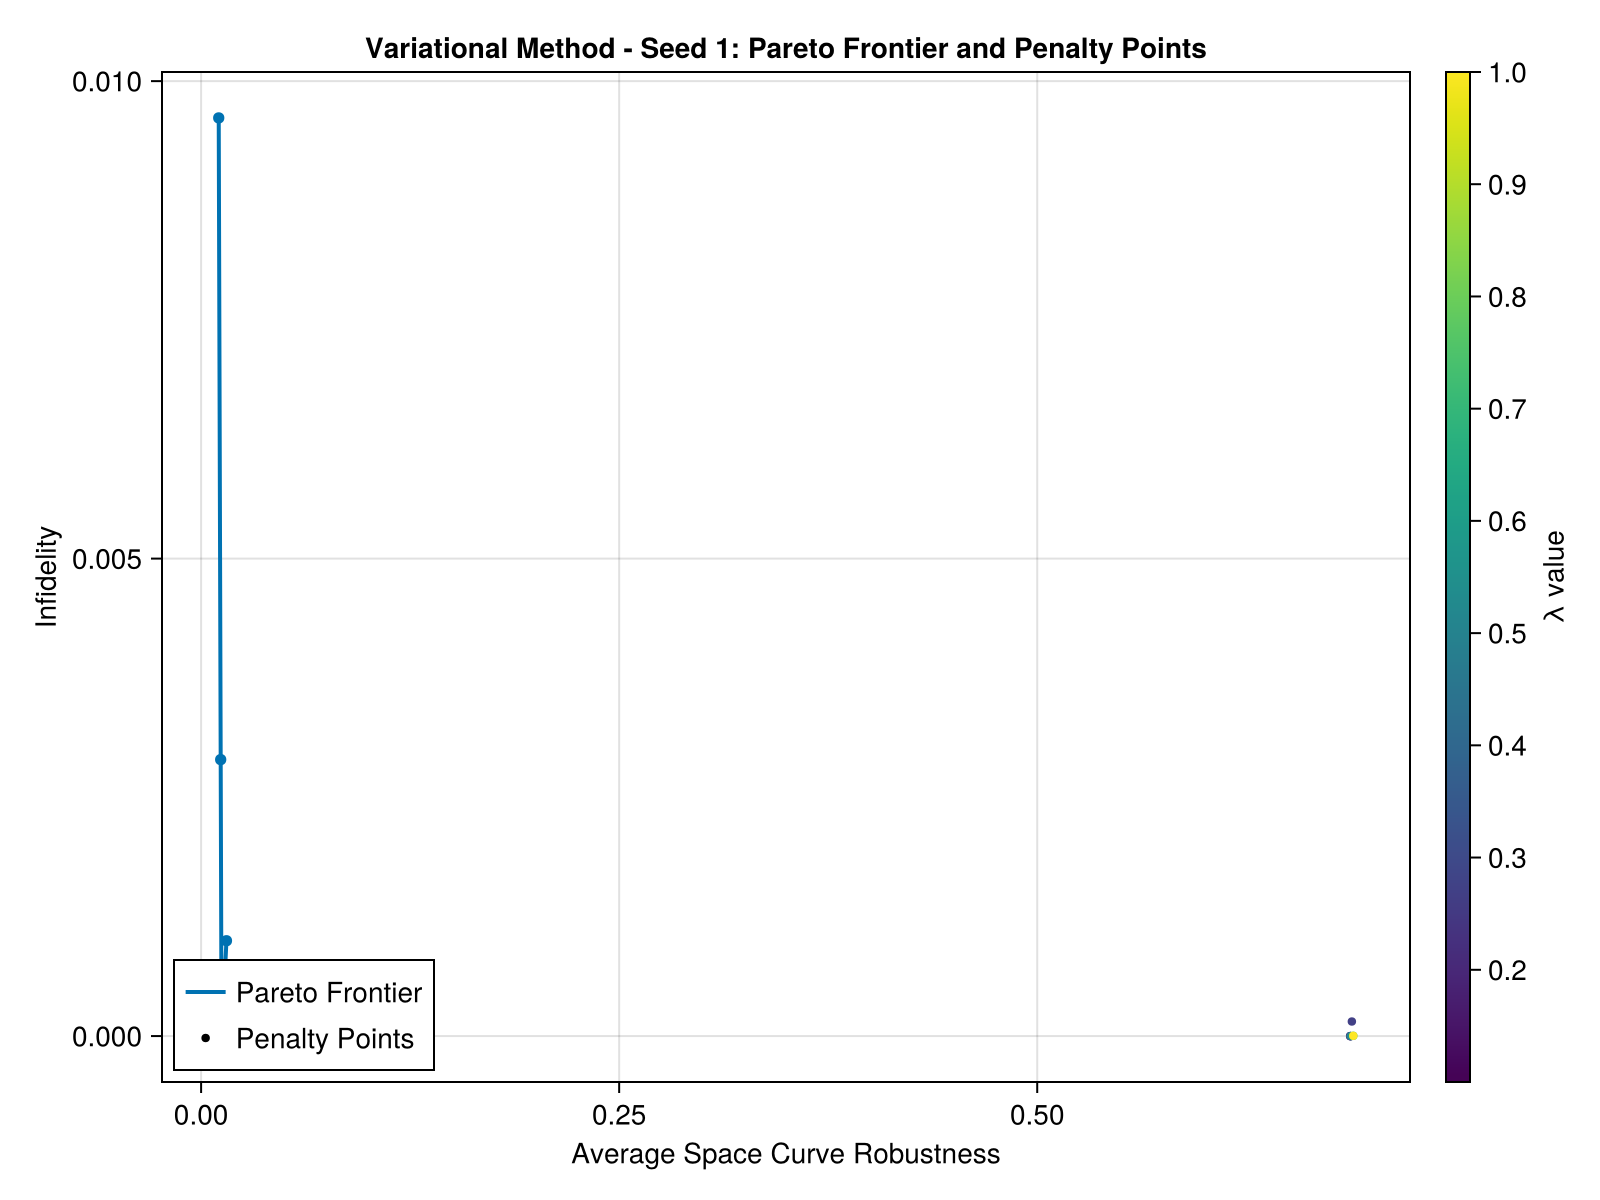

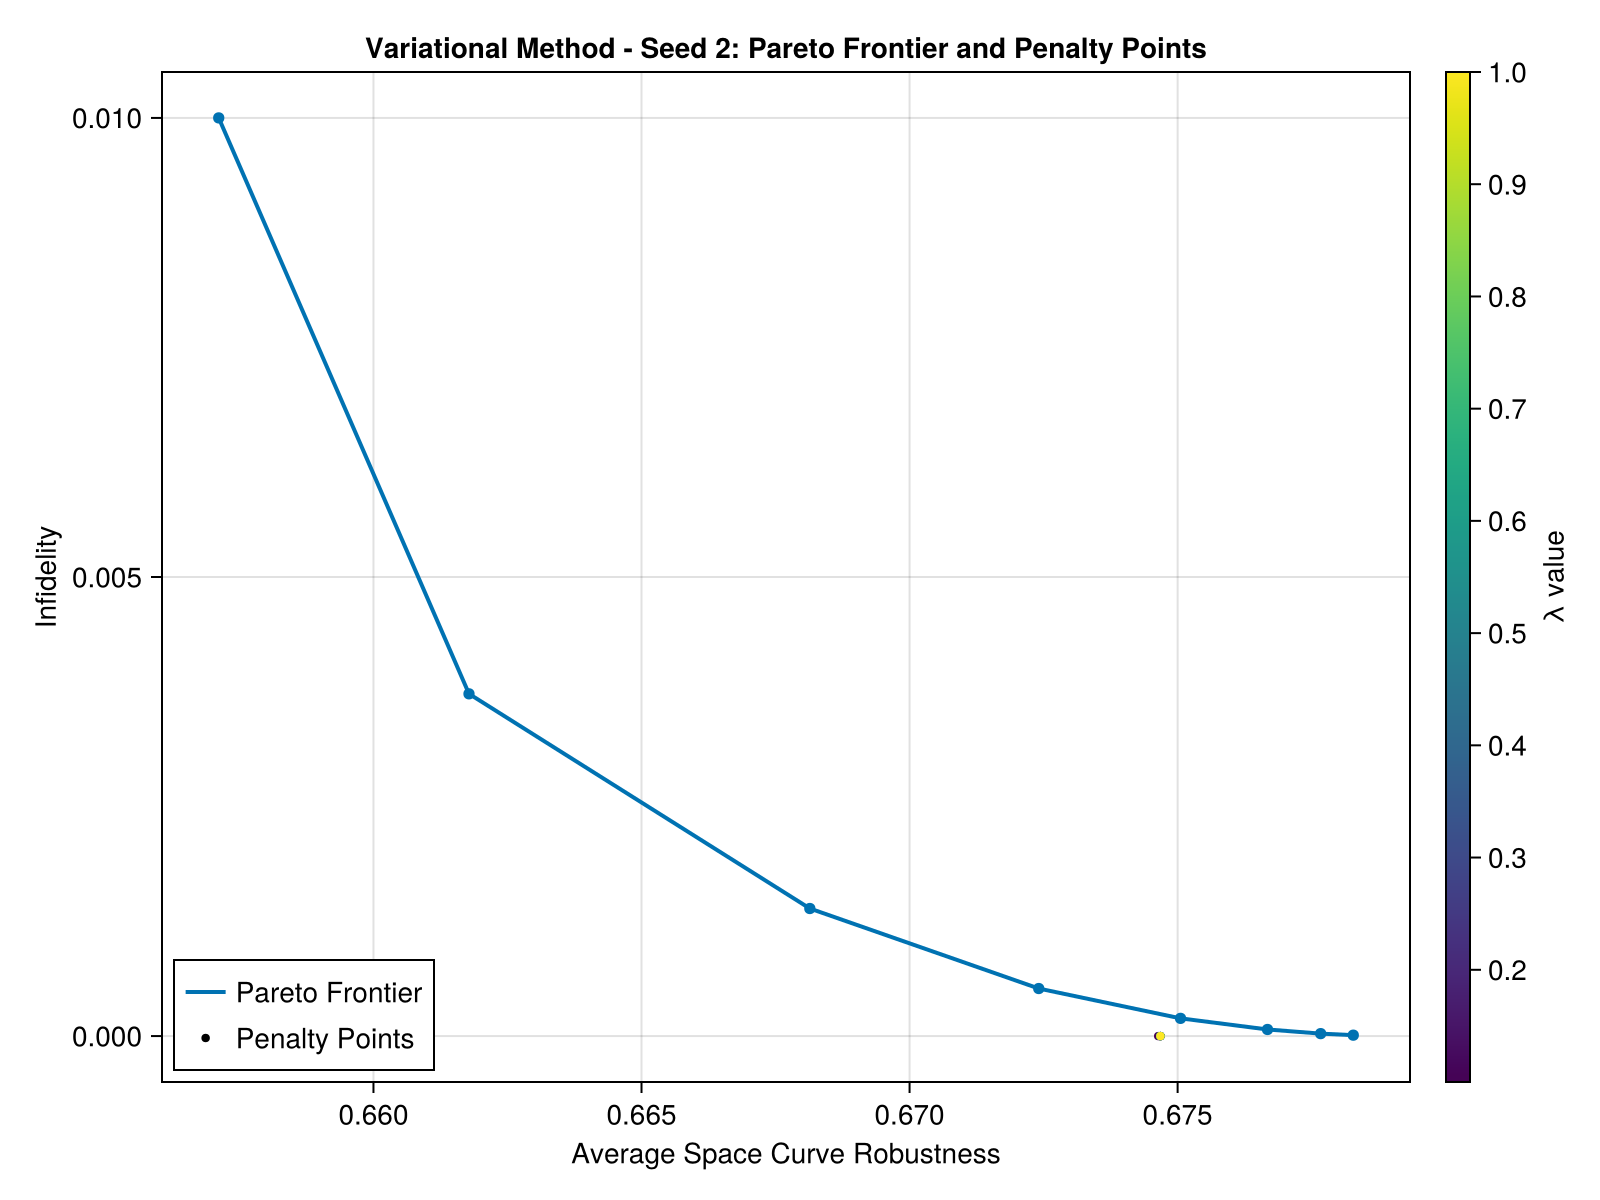

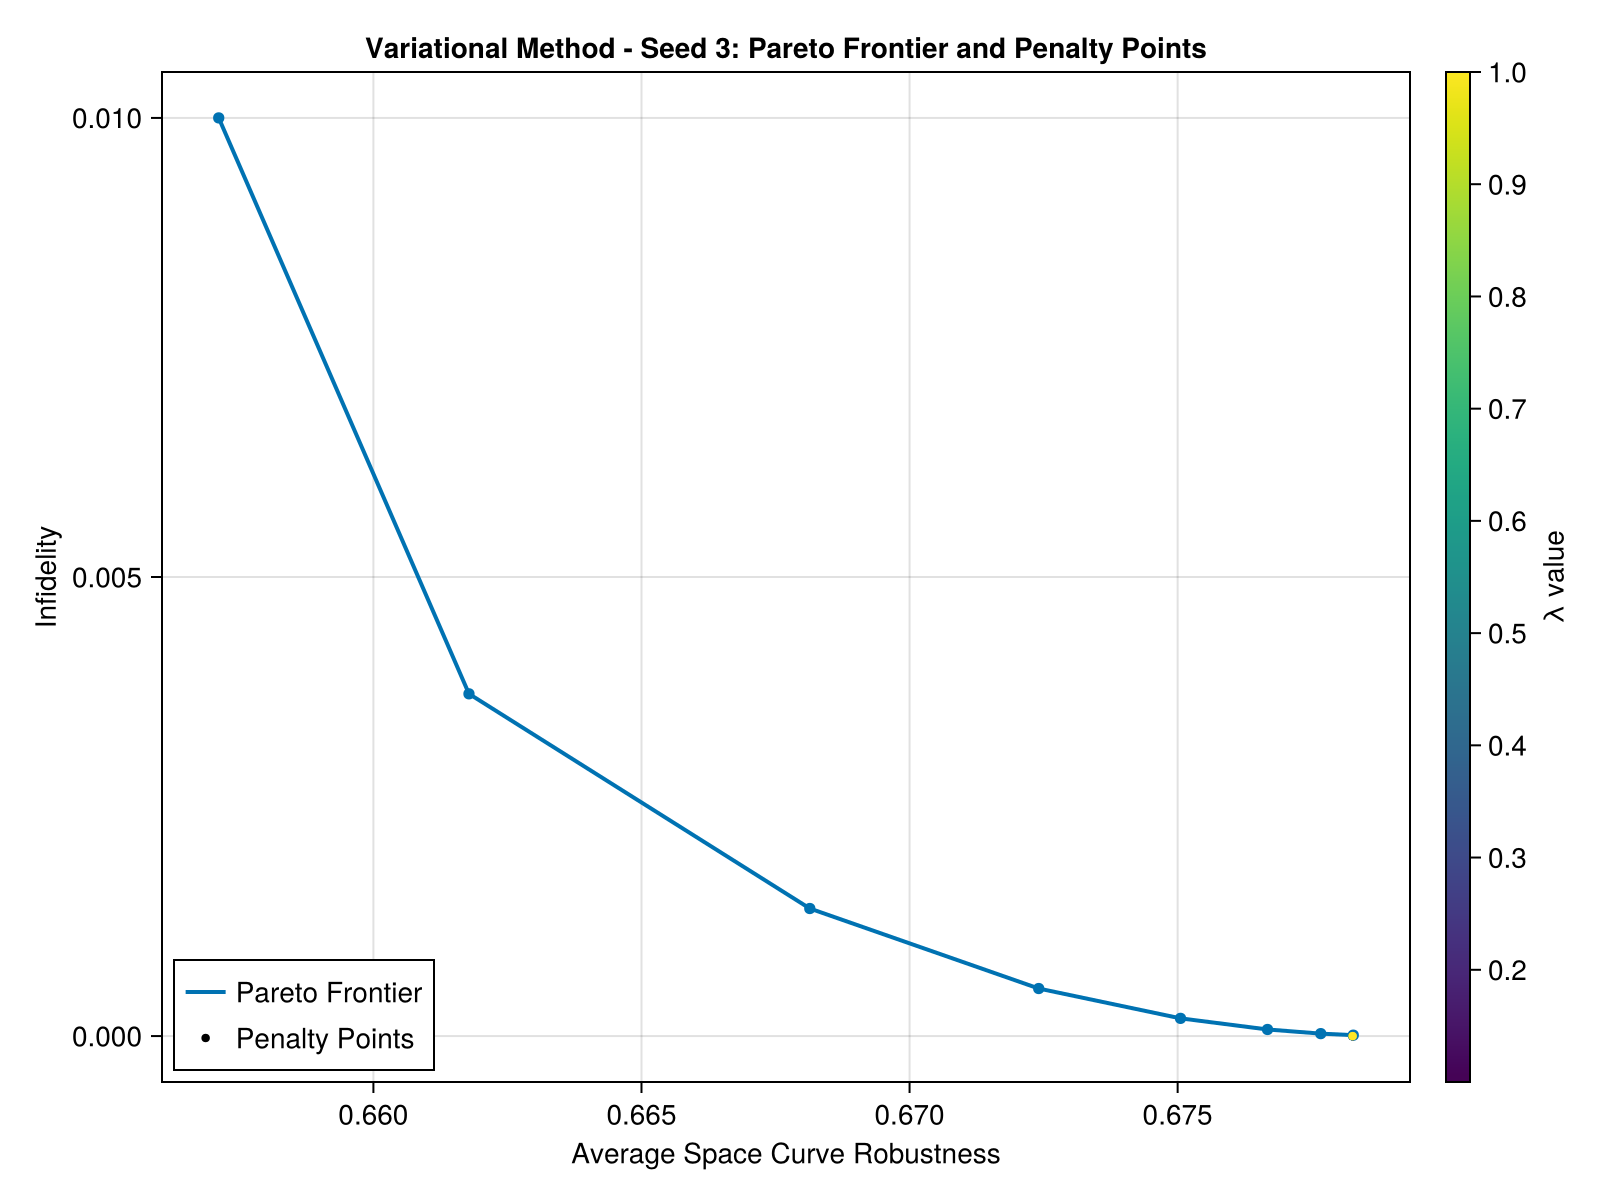

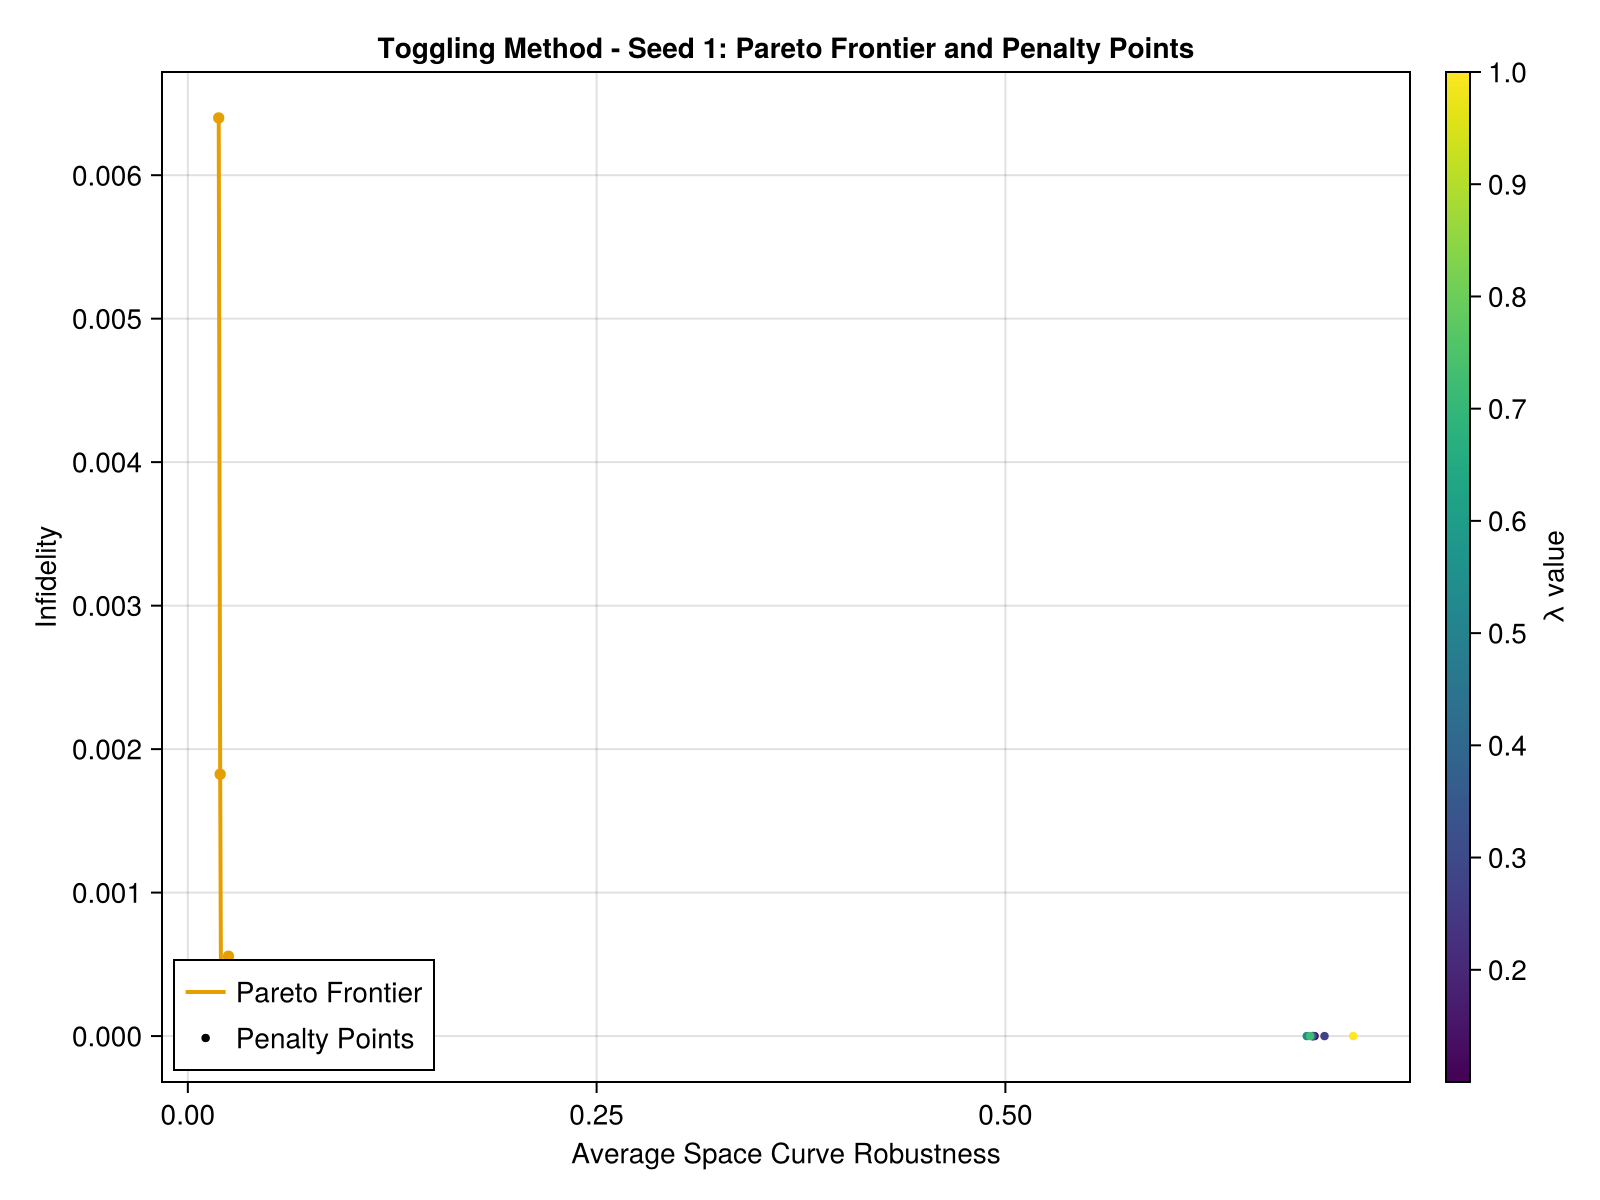

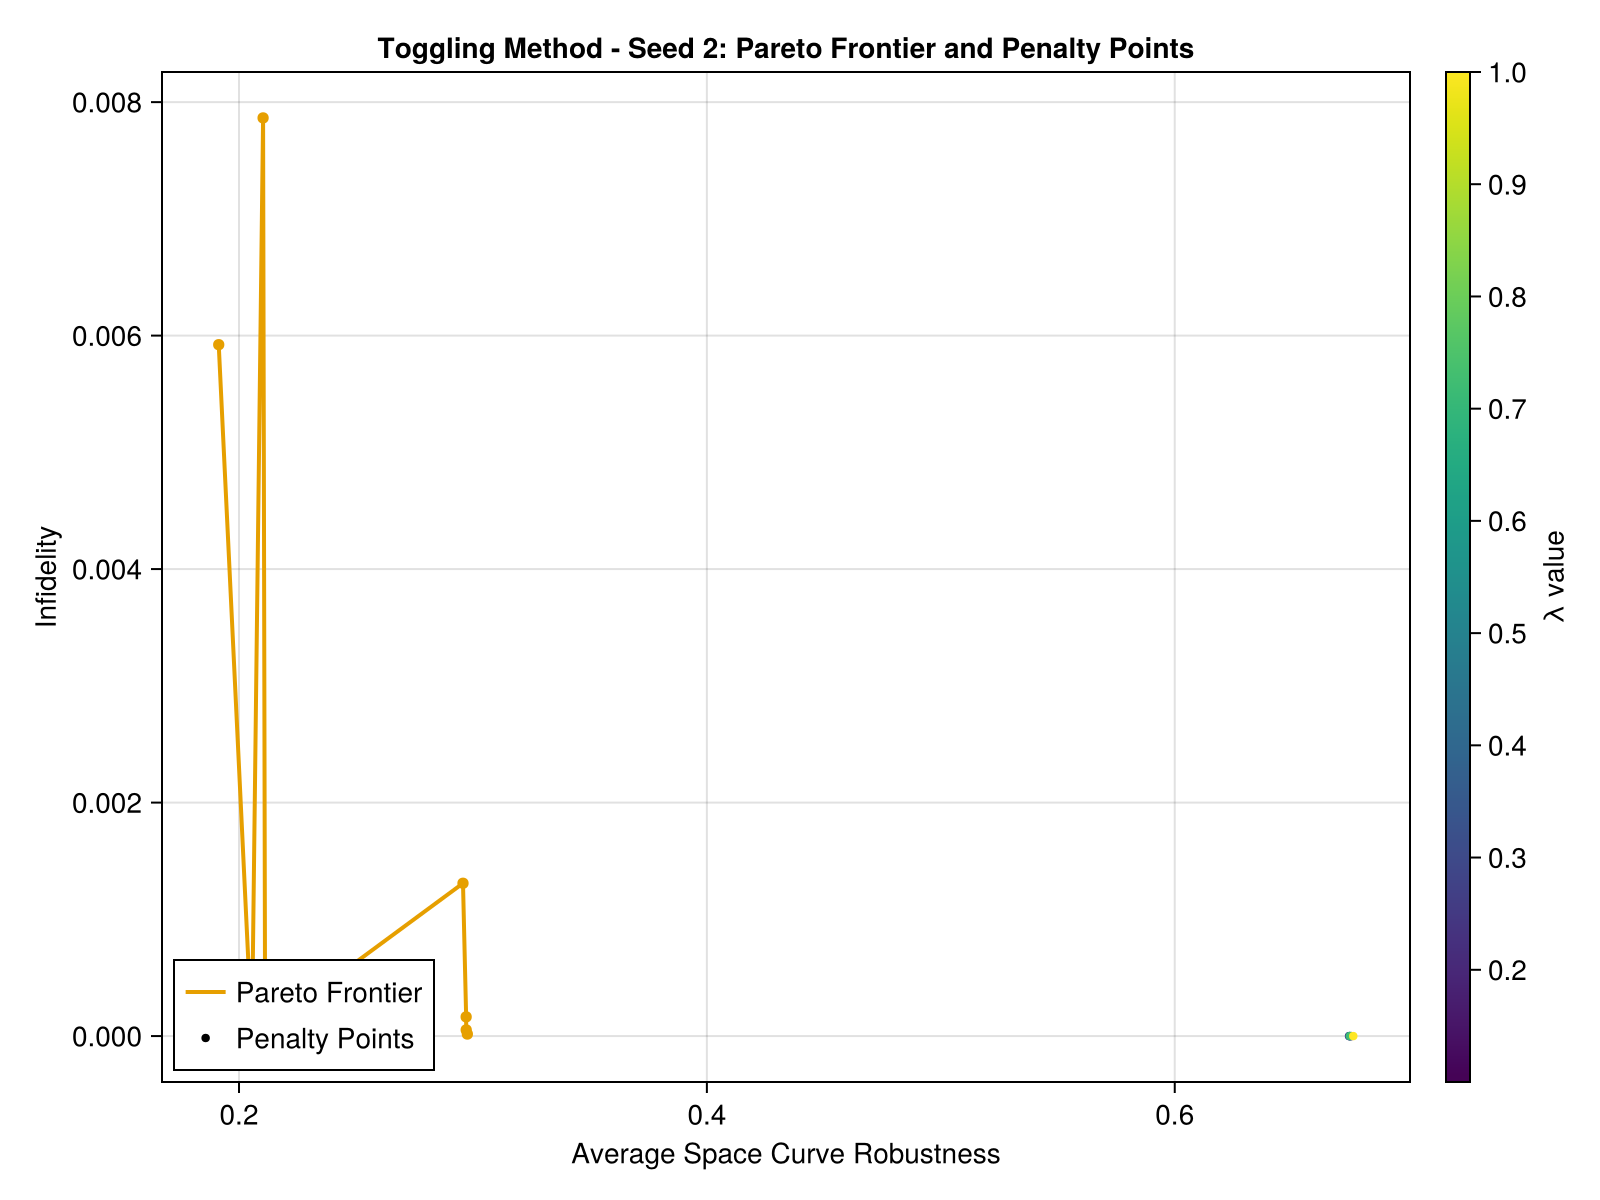

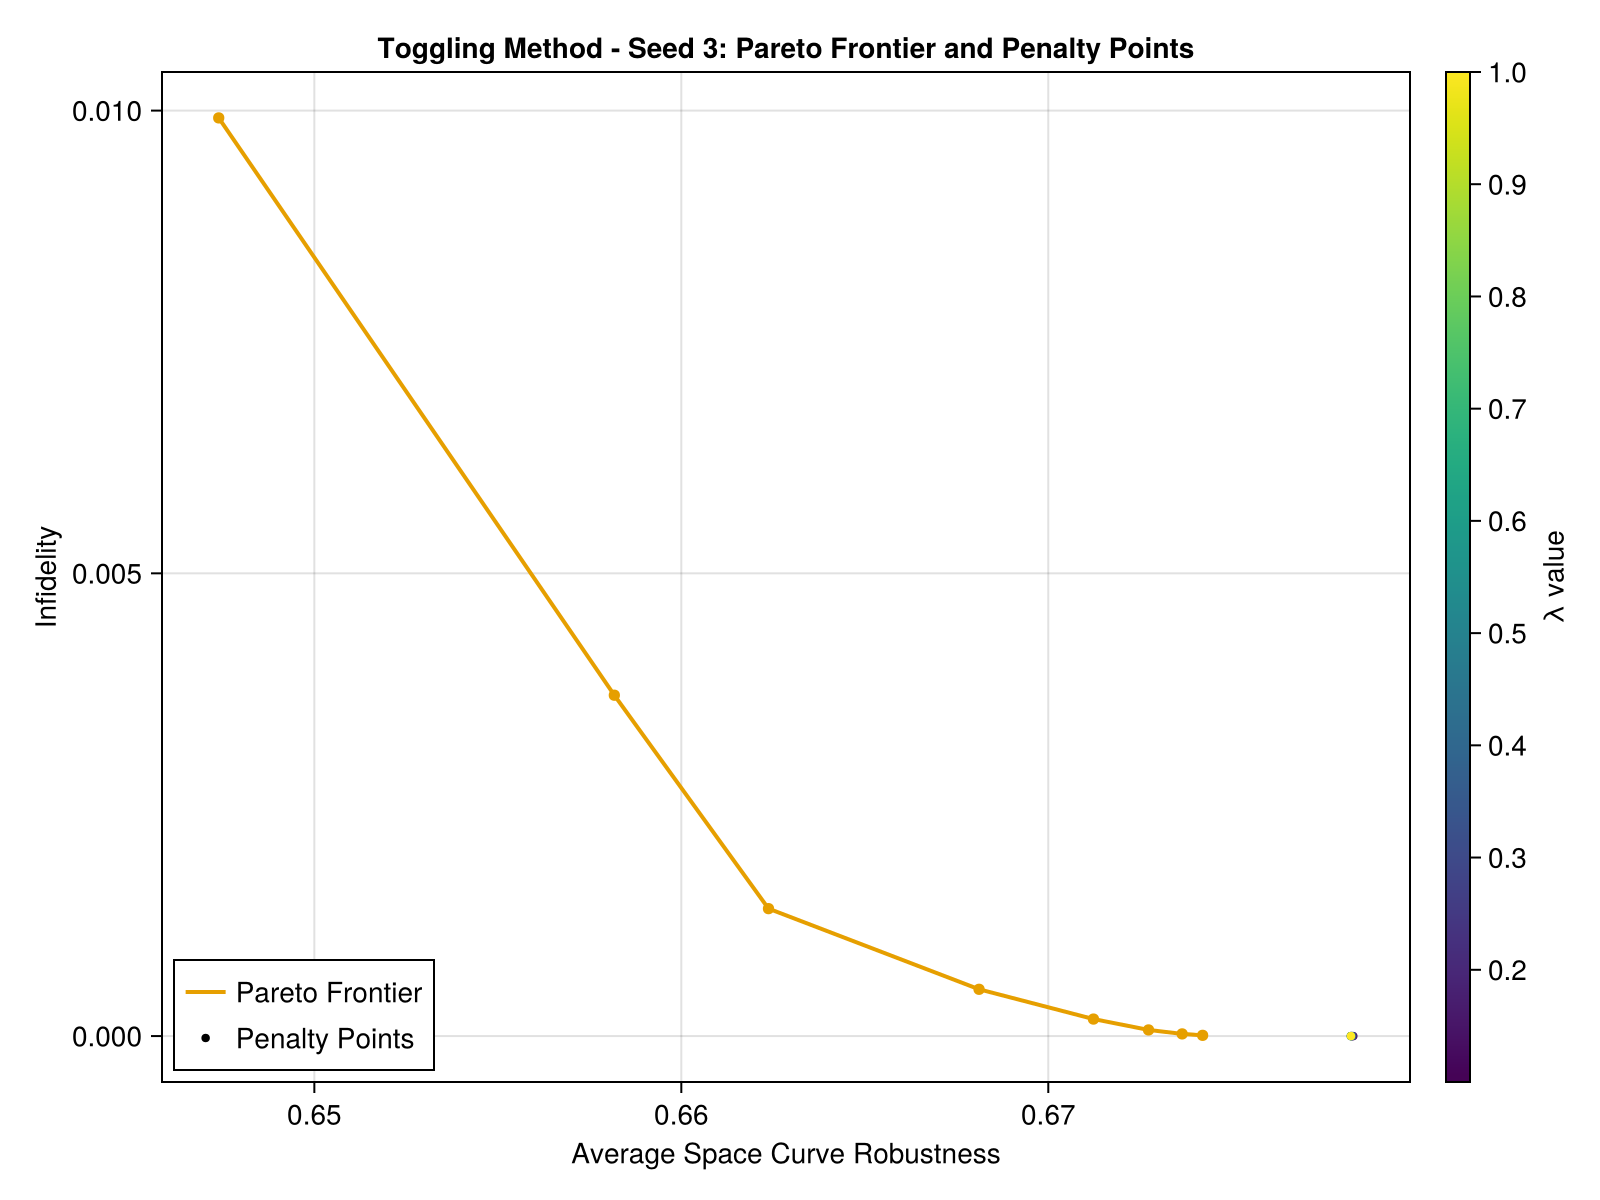

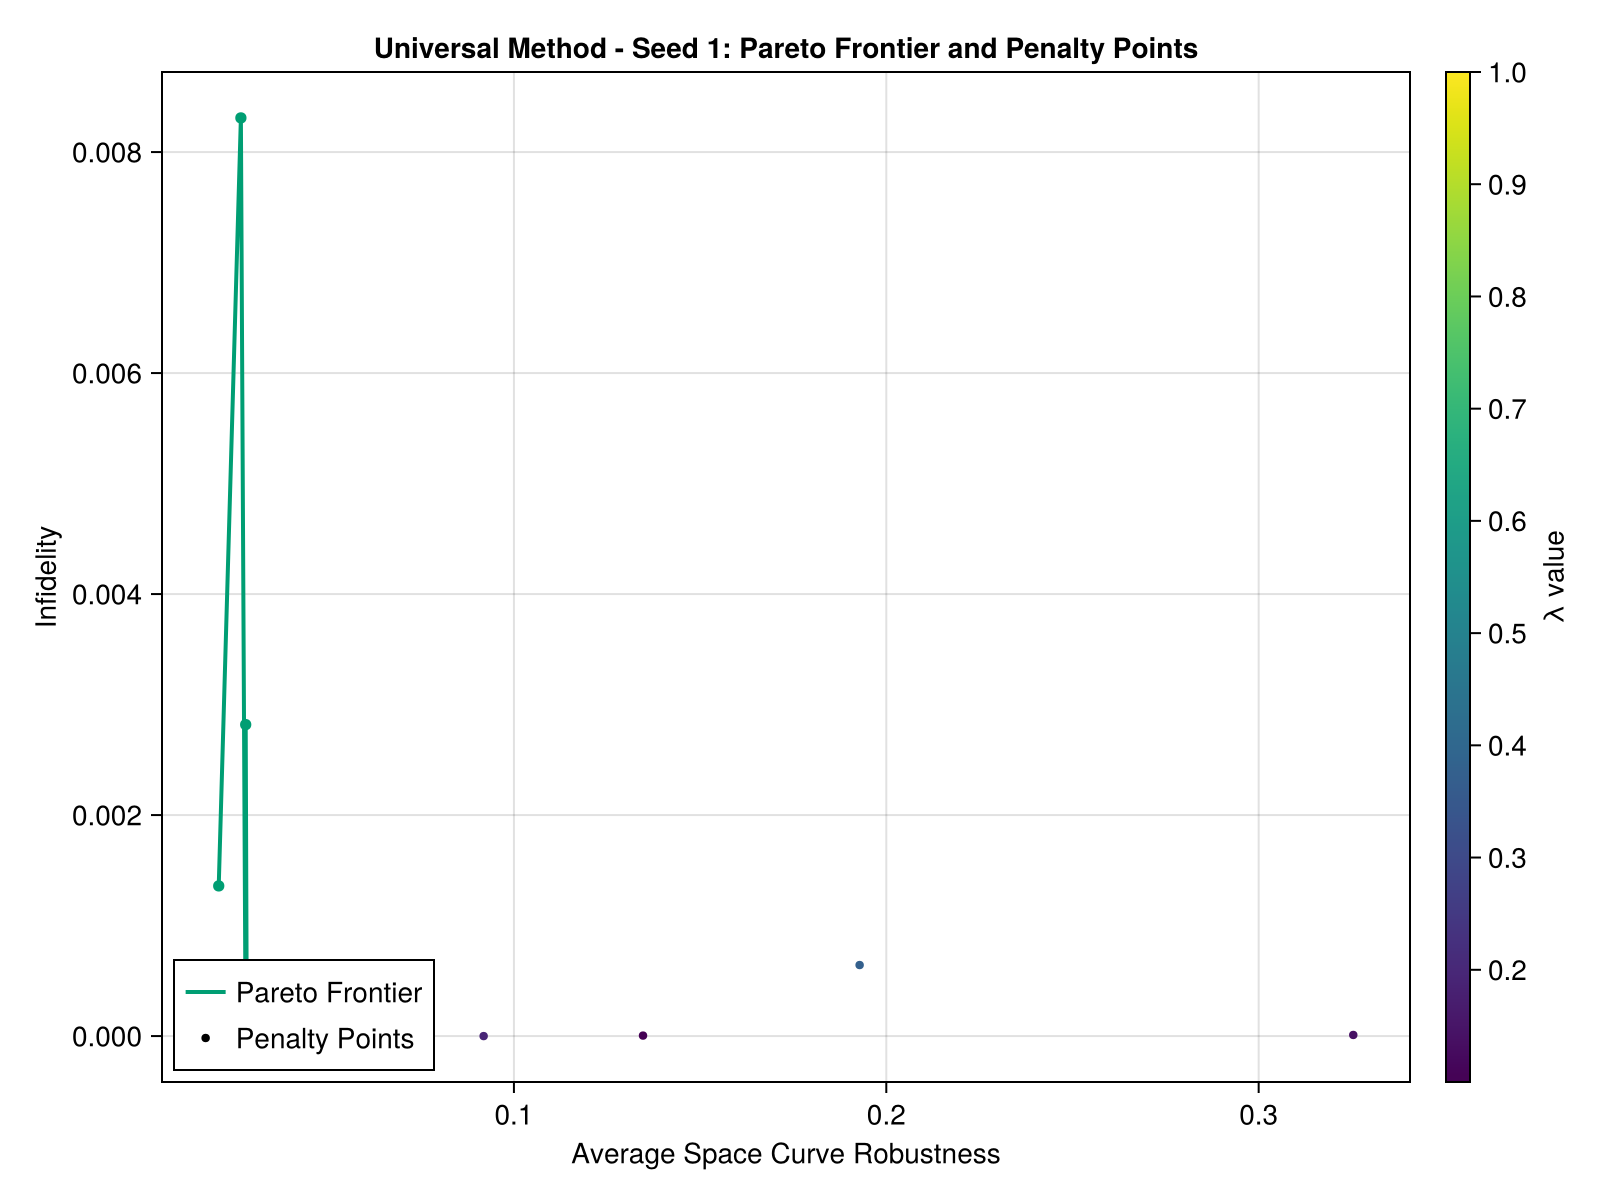

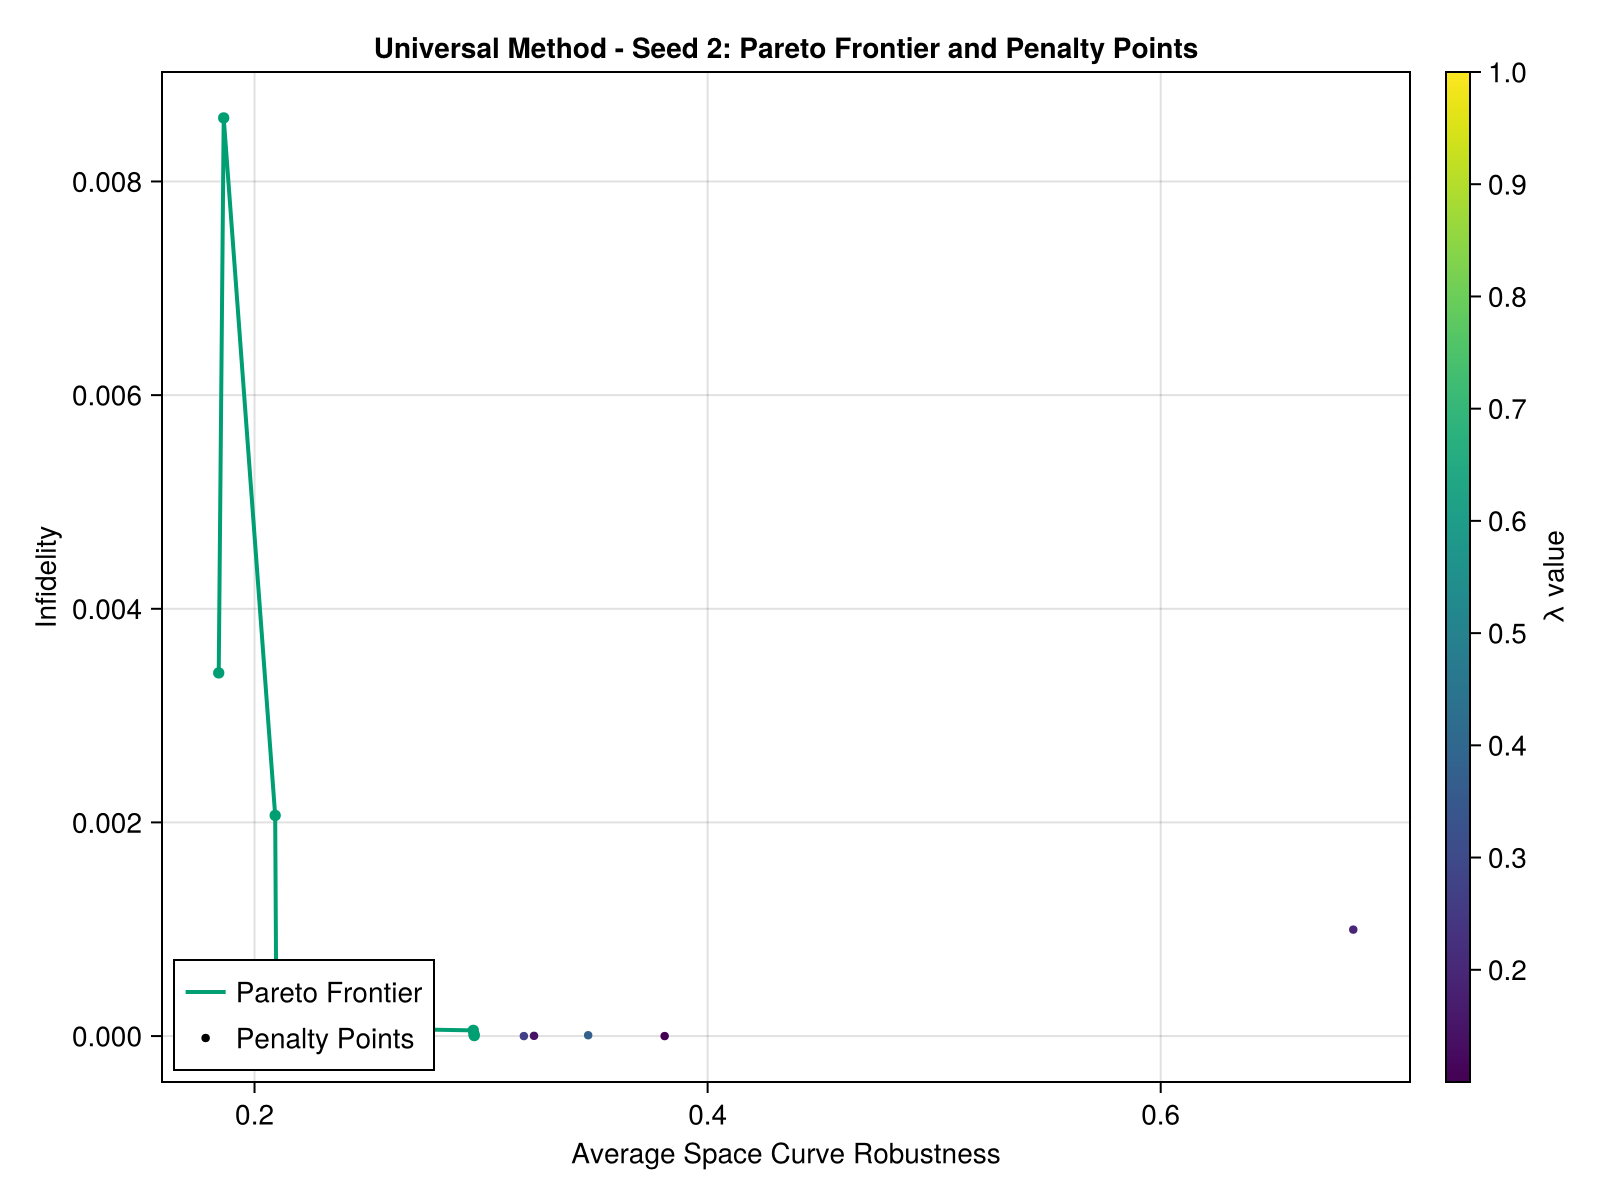

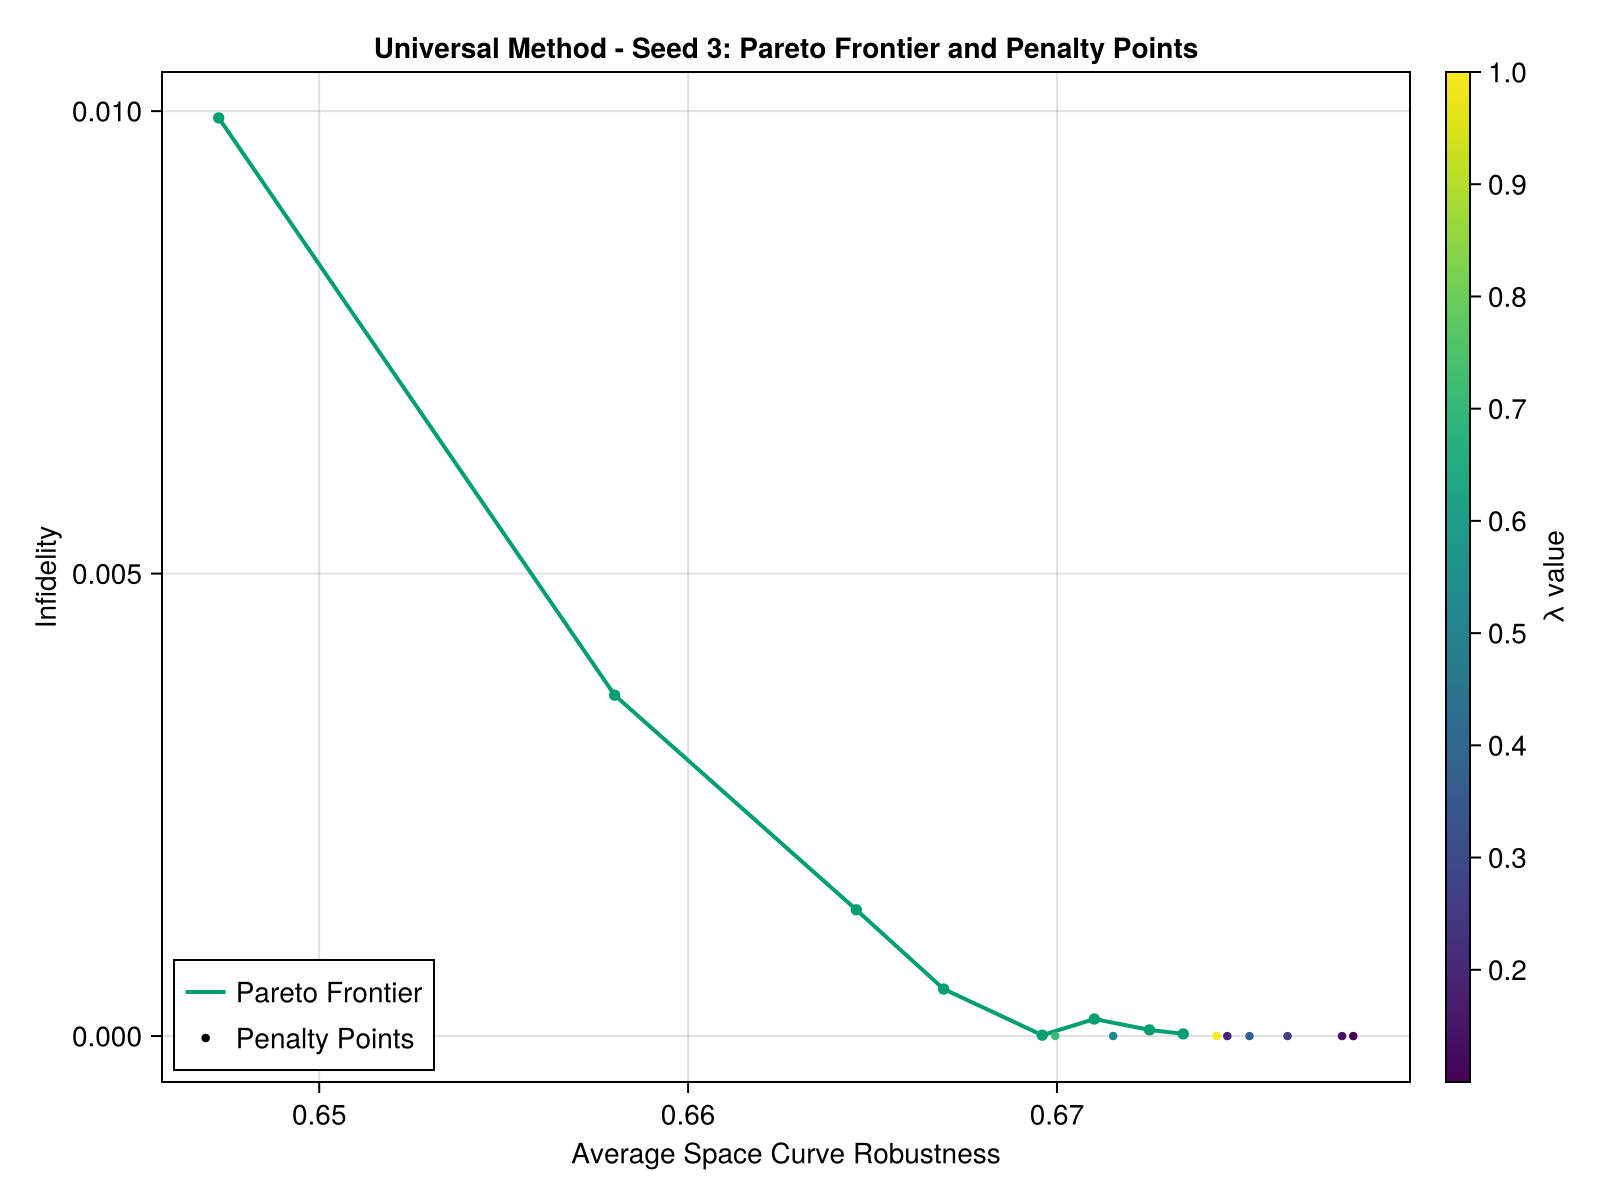

In [29]:
# Define colors for methods
# method_colors = [:blue, :red, :green]
colors = Makie.wong_colors()

method_names_plot = ["Variational", "Toggling", "Universal"]

H_err_add = PAULIS.X + PAULIS.Y + PAULIS.Z

for (method_idx, method_name) in enumerate(method_names_plot)
    println("Processing $method_name method...")
    
    # Get the appropriate problem arrays
    if method_idx == 1  # Variational
        pareto_probs = final_var_probs
        penalty_probs = pen_var_probs
    elseif method_idx == 2  # Toggling
        pareto_probs = final_tog_probs
        penalty_probs = pen_tog_probs
    else  # Universal
        pareto_probs = final_uni_probs
        penalty_probs = pen_uni_probs
    end
    
    # Create separate plot for each seed
    for s in 1:n_seeds
        fig = Figure(resolution=(800, 600))
        ax = Axis(fig[1, 1], 
                 xlabel="Average Space Curve Robustness", 
                 ylabel="Infidelity",
                 title="$method_name Method - Seed $s: Pareto Frontier and Penalty Points")
        
        # Pareto frontier points
        pareto_x = Float64[]
        pareto_y = Float64[]
        
        for j in 1:n_nines
            prob = pareto_probs[s, j]
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(pareto_x, avg_robustness)
            push!(pareto_y, 1-fidelity)
        end
        
        # Sort by x-axis for smooth line
        ord = sortperm(pareto_x)
        lines!(ax, pareto_x[ord], pareto_y[ord], 
               color=colors[method_idx], linewidth=2, 
               label="Pareto Frontier")
        Makie.scatter!(ax, pareto_x[ord], pareto_y[ord], 
                color=colors[method_idx], markersize=8)
        
        # Penalty points
        penalty_x = Float64[]
        penalty_y = Float64[]
        lambda_vals = Float64[]
        
        for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
            prob = penalty_probs[s, λ_idx]
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(penalty_x, avg_robustness)
            push!(penalty_y, 1-fidelity)
            push!(lambda_vals, λ)
        end
        
        # Color penalty points by lambda value
        Makie.scatter!(ax, penalty_x, penalty_y, 
                color=lambda_vals, colormap=:viridis, markersize=6,
                label="Penalty Points")
        
        # Add colorbar for lambda values
        Colorbar(fig[1, 2], limits=(minimum(sweep_rob_loss_λ), maximum(sweep_rob_loss_λ)),
                 colormap=:viridis, label="λ value")
        
        axislegend(ax, position=:lb)
        display(fig)
    end
end

#### comparing pareto frontiers of objectives

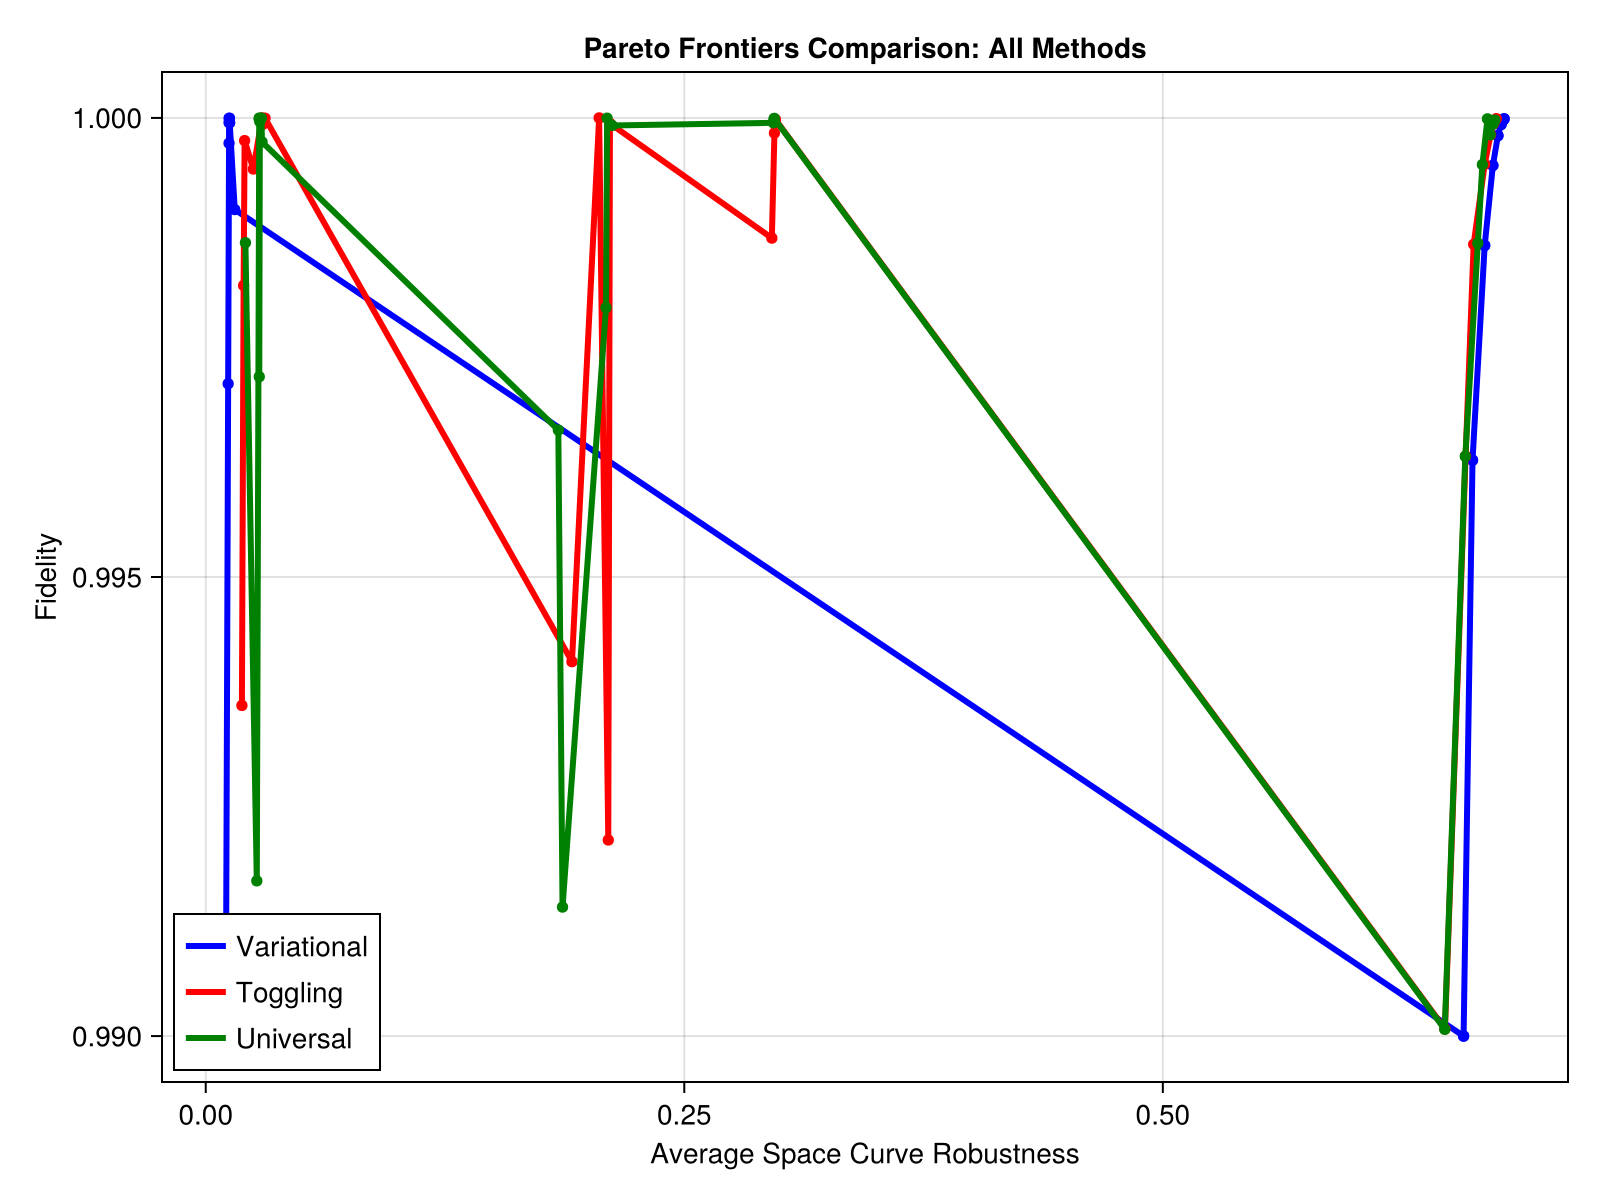

CairoMakie.Screen{IMAGE}


In [24]:
colors = Makie.wong_colors()

fig = Figure(resolution=(800, 600))
ax = Axis(fig[1, 1], 
         xlabel="Average Space Curve Robustness", 
         ylabel="Fidelity",
         title="Pareto Frontiers Comparison: All Methods")

pareto_arrays = [final_var_probs, final_tog_probs, final_uni_probs]

for (method_idx, method_name) in enumerate(method_names_plot)
    pareto_probs = pareto_arrays[method_idx]
    
    # Collect all points for this method across all seeds
    all_x = Float64[]
    all_y = Float64[]
    
    for s in 1:n_seeds
        for j in 1:n_nines
            prob = pareto_probs[s, j]
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(all_x, avg_robustness)
            push!(all_y, fidelity)
        end
    end
    
    # Sort by x-axis for smooth line
    ord = sortperm(all_x)
    lines!(ax, all_x[ord], all_y[ord], 
           color=colors[method_idx], linewidth=3, 
           label=method_name)
    Makie.scatter!(ax, all_x[ord], all_y[ord], 
            color=colors[method_idx], markersize=8)
end

axislegend(ax, position=:lb)
display(fig)



### comparing penalty method performace of objective

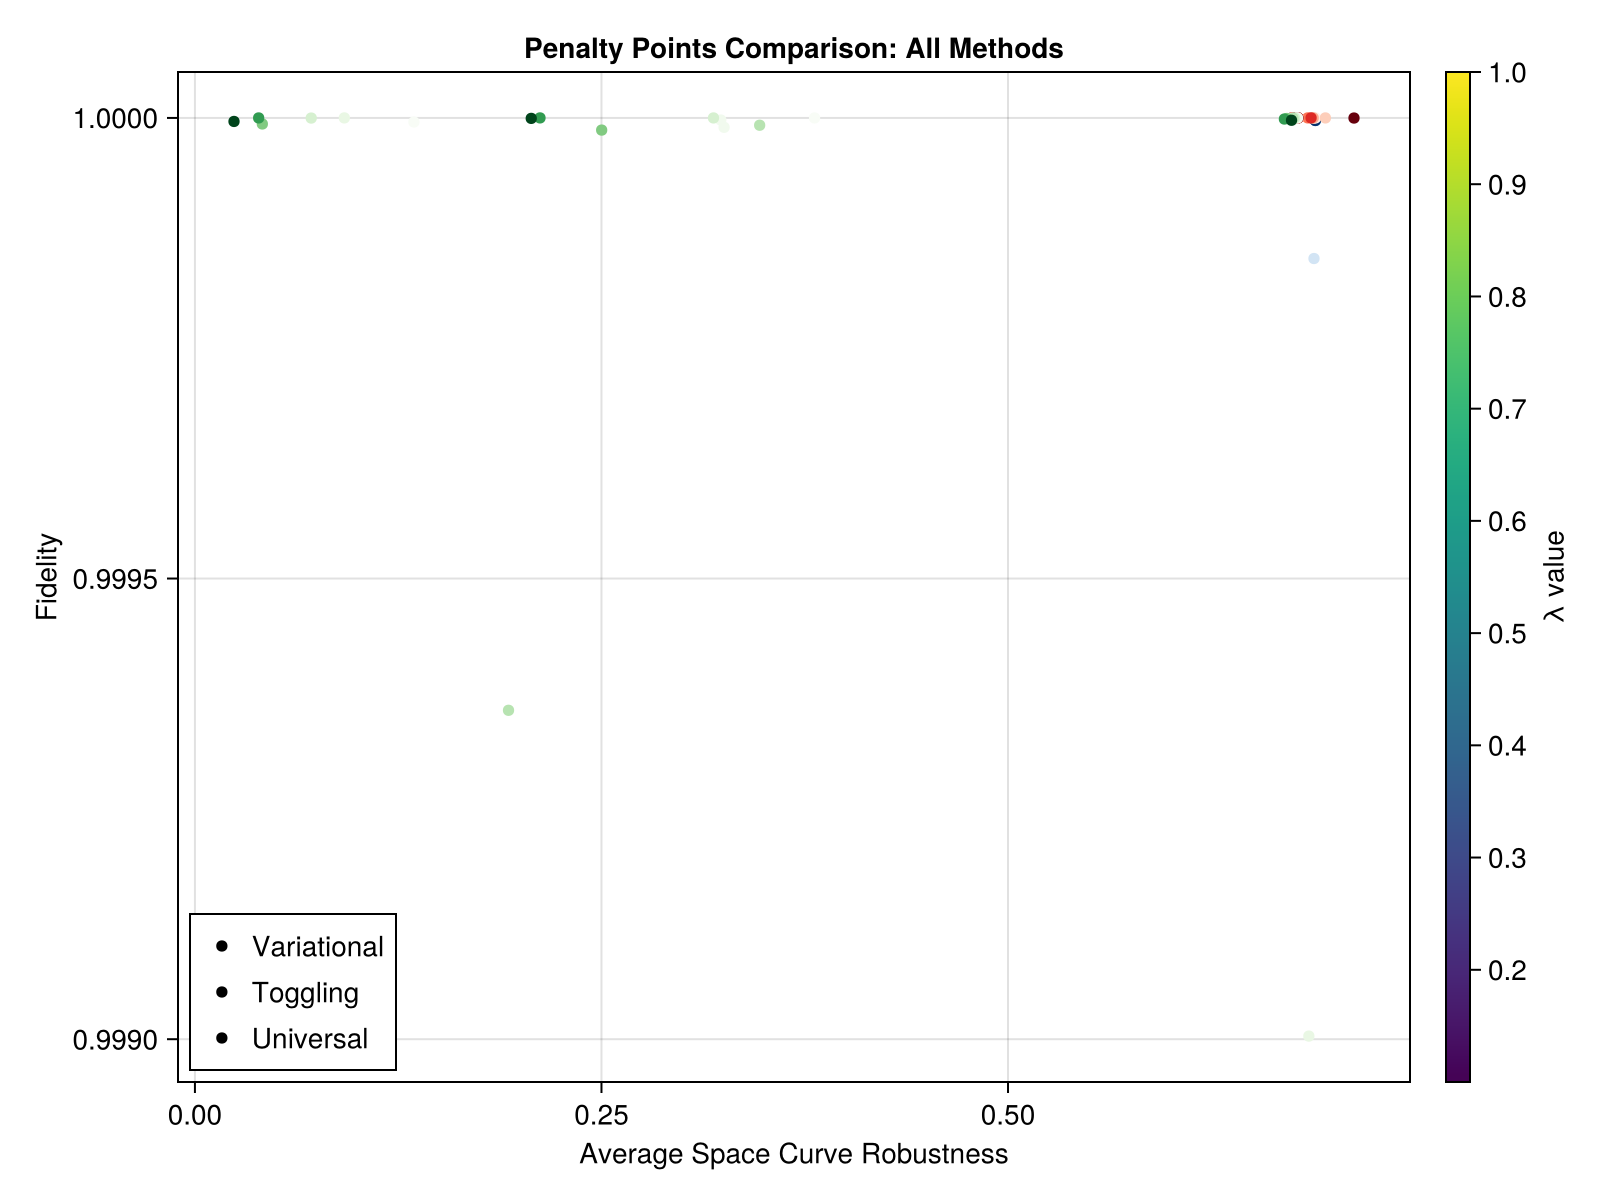

In [27]:
fig = Figure(resolution=(800, 600))
ax = Axis(fig[1, 1], 
         xlabel="Average Space Curve Robustness", 
         ylabel="Fidelity",
         title="Penalty Points Comparison: All Methods")

penalty_arrays = [pen_var_probs, pen_tog_probs, pen_uni_probs]

for (method_idx, method_name) in enumerate(method_names_plot)
    penalty_probs = penalty_arrays[method_idx]
    
    # Collect all points for this method across all seeds and lambdas
    all_x = Float64[]
    all_y = Float64[]
    all_lambda = Float64[]
    
    for s in 1:n_seeds
        for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
            prob = penalty_probs[s, λ_idx]
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(all_x, avg_robustness)
            push!(all_y, fidelity)
            push!(all_lambda, λ)
        end
    end
    
    # Use different color schemes for each method to distinguish them
    colormap = [:Blues, :Reds, :Greens][method_idx]
    Makie.scatter!(ax, all_x, all_y, 
            color=all_lambda, colormap=colormap, markersize=8,
            label=method_name)
end

# Create custom colorbar showing lambda range
Colorbar(fig[1, 2], limits=(minimum(sweep_rob_loss_λ), maximum(sweep_rob_loss_λ)),
         colormap=:viridis, label="λ value")

axislegend(ax, position=:lb)
display(fig)

println("All plots completed!")

# Optional: Save plots
# save("pareto_comparison.png", fig)



In [18]:
# Summary statistics
println("\nSummary Statistics:")
println("==================")

for (method_idx, method_name) in enumerate(method_names_plot)
    println("\n$method_name Method:")
    
    if method_idx == 1
        probs = final_var_probs
    elseif method_idx == 2
        probs = final_tog_probs
    else
        probs = final_uni_probs
    end
    
    robustness_vals = Float64[]
    fidelity_vals = Float64[]
    
    for s in 1:n_seeds, j in 1:n_nines
        prob = probs[s, j]
        X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
        Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
        Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
        avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
        fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
        
        push!(robustness_vals, avg_robustness)
        push!(fidelity_vals, fidelity)
    end
    
    println("  Robustness range: $(round(minimum(robustness_vals), digits=6)) - $(round(maximum(robustness_vals), digits=6))")
    println("  Fidelity range: $(round(minimum(fidelity_vals), digits=6)) - $(round(maximum(fidelity_vals), digits=6))")
    println("  Mean robustness: $(round(mean(robustness_vals), digits=6))")
    println("  Mean fidelity: $(round(mean(fidelity_vals), digits=6))")
end

### sanity checks 

Final Fidelity Table

In [19]:
# H_drive_add = H_drive
# εs = 0:0.005:0.2
# # colors = Makie.wong_colors()

# # Get fid for each problem
# for seed_idx in 1:n_seeds
#     display("\nseed idx = $seed_idx:")
#     display("Final f | Base Fidelity | Add Fidelity | Mult Fidelity ")
#     display("-" ^ 40)
#     for (j, f) in enumerate(final_fid_floor)
#             def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
#             add_fid = unitary_rollout_fidelity(final_add_probs[seed_idx, j].trajectory, sys)
#             mult_fid = unitary_rollout_fidelity(final_mult_probs[seed_idx, j].trajectory, sys)
#             display("$(lpad(round(f, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(add_fid, digits=6), 12)) | $(lpad(round(mult_fid, digits=6), 13)) |")
#     end
# end

Plot Fidelity vs Error

In [20]:
# εs     = 0:0.01:0.5
# floors = final_fid_floor

# # Build a continuous colormap and a normalizer for the floor values
# cmap   = cgrad(:viridis)  # perceptually uniform
# fmin, fmax = extrema(floors)
# nfloor(x) = fmax == fmin ? 0.5 : (x - fmin) / (fmax - fmin)  # safeguard for flat ranges

# # Helper: get the color for a given floor
# floor_color(f) = cmap[nfloor(f)]

# # Helper to plot one seed, additive-only
# function plot_seed_additive(seed_idx; εs=εs, floors=floors)
#     fig = Figure(resolution=(950,600))
#     ax = Axis(fig[1,1];
#         title = "Seed $(seed_idx) — additive error",
#         xlabel = "ε",
#         ylabel = "Fidelity"
#     )

#     for j in 1:length(floors)
#         f = floors[j]
#         c = floor_color(f)

#         # Base (default) trajectory at this floor
#         def_traj  = default_probs[seed_idx, j].trajectory
#         # Optimized (toggle) trajectory at this floor
#         add_traj  = final_add_probs[seed_idx, j].trajectory

#         ys_def = [unitary_rollout_fidelity(
#                       def_traj,
#                       QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]
#         ys_add = [unitary_rollout_fidelity(
#                       add_traj,
#                       QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]

#         # same hue for the pair; dashed = base, solid = optimized
#         lines!(ax, εs, ys_def, color=c, linestyle=:dash,
#                label="base @ $(round(f; digits=6))")
#         lines!(ax, εs, ys_add, color=c, linestyle=:solid,
#                label="add toggle @ $(round(f; digits=6))")
#     end

#     # Legend + continuous colorbar keyed to floor
#     axislegend(ax, position=:lb, nbanks=2)
#     Colorbar(fig[1,2], colormap=cmap, limits=(fmin, fmax), label="Fidelity floor")

#     fig
# end

# # Helper to plot one seed, multiplicative-only
# function plot_seed_multiplicative(seed_idx; εs=εs, floors=floors)
#     fig = Figure(resolution=(950,600))
#     ax = Axis(fig[1,1];
#         title = "Seed $(seed_idx) — multiplicative error",
#         xlabel = "ε",
#         ylabel = "Fidelity"
#     )

#     for j in 1:length(floors)
#         f = floors[j]
#         c = floor_color(f)

#         # Base (default) trajectory at this floor
#         def_traj  = default_probs[seed_idx, j].trajectory
#         # Optimized (toggle) trajectory at this floor
#         mult_traj = final_mult_probs[seed_idx, j].trajectory

#         ys_def = [unitary_rollout_fidelity(
#                       def_traj,
#                       QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]
#         ys_mult = [unitary_rollout_fidelity(
#                        mult_traj,
#                        QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
#                    ) for ε in εs]

#         lines!(ax, εs, ys_def,  color=c, linestyle=:dash,
#                label="base @ $(round(f; digits=6))")
#         lines!(ax, εs, ys_mult, color=c, linestyle=:solid,
#                label="mult toggle @ $(round(f; digits=6))")
#     end

#     axislegend(ax, position=:lb, nbanks=2)
#     Colorbar(fig[1,2], colormap=cmap, limits=(fmin, fmax), label="Fidelity floor")

#     fig
# end


In [21]:
# εs     = 0:0.01:0.5
# using Makie: LineElement


# const LINE_ALPHA = 0.8
# const LINEWIDTH  = 1.2
# const YMAX       = 1.0

# function finalize_axes!(fig, ax; cmap, fmin, fmax, ymin_seen)
#     ylo = 0.9#min(0.9, ymin_seen)                   # expand lower only if needed
#     Makie.ylims!(ax, ylo, 1.0)                  # qualify to avoid Plots clash

#     ax.yticks = 0.90:0.02:1.00
#     ax.ytickformat = vals -> string.(round.(vals; digits=2))

#     # Optional grid styling (works if your Makie version exposes these fields):
#     # ax.xgridvisible = true;  ax.ygridvisible = true
#     # ax.xgridcolor   = (:gray, 0.25); ax.ygridcolor = (:gray, 0.25)
#     # ax.xgridwidth   = 0.8;           ax.ygridwidth = 0.8

#     style_elems = [
#         LineElement(color=:black, linestyle=:dash,  linewidth=1.2),
#         LineElement(color=:black, linestyle=:solid, linewidth=1.2),
#     ]
#     Makie.axislegend(ax, style_elems, ["base", "optimized"], position=:lb)
#     Makie.Colorbar(fig[1,2], colormap=cmap, limits=(fmin, fmax), label="Fidelity floor")
# end

# function plot_seed_additive(seed_idx; εs=εs, floors=floors)
#     fig = Figure(resolution=(950,600))
#     ax = Axis(fig[1,1];
#         title = "Seed $(seed_idx) — additive error",
#         xlabel = "ε",
#         ylabel = "Fidelity"
#     )

#     ymin_seen = Inf

#     for j in 1:length(floors)
#         f = floors[j]
#         c = floor_color(f)

#         def_traj = default_probs[seed_idx, j].trajectory
#         add_traj = final_add_probs[seed_idx, j].trajectory

#         ys_def = [unitary_rollout_fidelity(
#                       def_traj,
#                       QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]
#         ys_add = [unitary_rollout_fidelity(
#                       add_traj,
#                       QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]

#         # Track global minimum so we never hide data
#         ymin_seen = min(ymin_seen, minimum(ys_def), minimum(ys_add))

#         # Same hue for the pair; dashed = base, solid = optimized
#         lines!(ax, εs, ys_def, color=(c, LINE_ALPHA), linestyle=:dash,  linewidth=LINEWIDTH)
#         lines!(ax, εs, ys_add, color=(c, LINE_ALPHA), linestyle=:solid, linewidth=LINEWIDTH)
#     end

#     finalize_axes!(fig, ax; cmap=cmap, fmin=fmin, fmax=fmax, ymin_seen=ymin_seen)
#     fig
# end

# function plot_seed_multiplicative(seed_idx; εs=εs, floors=floors)
#     fig = Figure(resolution=(950,600))
#     ax = Axis(fig[1,1];
#         title = "Seed $(seed_idx) — multiplicative error",
#         xlabel = "ε",
#         ylabel = "Fidelity"
#     )

#     ymin_seen = Inf

#     for j in 1:length(floors)
#         f = floors[j]
#         c = floor_color(f)

#         def_traj  = default_probs[seed_idx, j].trajectory
#         mult_traj = final_mult_probs[seed_idx, j].trajectory

#         ys_def = [unitary_rollout_fidelity(
#                       def_traj,
#                       QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]
#         ys_mult = [unitary_rollout_fidelity(
#                        mult_traj,
#                        QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
#                    ) for ε in εs]

#         ymin_seen = min(ymin_seen, minimum(ys_def), minimum(ys_mult))

#         lines!(ax, εs, ys_def,  color=(c, LINE_ALPHA), linestyle=:dash,  linewidth=LINEWIDTH)
#         lines!(ax, εs, ys_mult, color=(c, LINE_ALPHA), linestyle=:solid, linewidth=LINEWIDTH)
#     end

#     finalize_axes!(fig, ax; cmap=cmap, fmin=fmin, fmax=fmax, ymin_seen=ymin_seen)
#     fig
# end


In [22]:
# using JLD2
# using Dates

# # Collect trajectories only (lighter than storing whole problem objects)
# default_trajs    = [default_probs[i, j].trajectory    for i in 1:n_seeds, j in 1:n_nines]
# warm_add_trajs   = [init_var_probs[i, j].trajectory   for i in 1:n_seeds, j in 1:n_nines]
# warm_mult_trajs  = [warm_mult_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:n_nines]
# final_add_trajs  = [final_add_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:n_nines]
# final_mult_trajs = [final_mult_probs[i, j].trajectory for i in 1:n_seeds, j in 1:n_nines]

# # Optional: fidelity traces you computed
# fid_traces = Dict(
#     "init_def_fids"  => init_def_fids,
#     "init_add_fids"  => init_add_fids,
#     "init_mult_fids" => init_mult_fids,
# )

# # Minimal metadata to reconstruct the setup
# meta = Dict(
#     "T" => T,
#     "Δt" => Δt,
#     "U_goal" => U_goal,
#     "n_seeds" => n_seeds,
#     "n_nines" => n_nines,
#     "final_fid_floor" => final_fid_floor,
#     "control_bounds" => control_bounds,
#     "n_drives" => n_drives,
# )

# # Make an artifacts/ folder and generate a timestamped filename
# mkpath("artifacts")
# timestamp = Dates.format(Dates.now(), "yyyymmdd_HHMMSS")
# outfile = joinpath("artifacts", "trajectories_$(timestamp).jld2")

# @info "Saving trajectories to $outfile"
# @save outfile default_trajs warm_add_trajs warm_mult_trajs final_add_trajs final_mult_trajs fid_traces meta
# @info "Done. Saved keys: default_trajs, warm_add_trajs, warm_mult_trajs, final_add_trajs, final_mult_trajs, fid_traces, meta"


To load the data for later, use:

In [23]:
# using JLD2
# @load "artifacts/trajectories_YYYYMMDD_HHMMSS.jld2" default_trajs warm_add_trajs warm_mult_trajs final_add_trajs final_mult_trajs fid_traces meta
